<a href="https://colab.research.google.com/github/U-11-Agar/time_series_bots-/blob/main/%F0%9F%A4%96lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization
from keras.losses import mean_squared_error
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

BASE_URL = 'https://www.alphavantage.co/query?'
API_KEY = 'K37TOUDE2WB29LQJ'
SYMBOL = 'BTCINR'  # Example forex exchange symbol
BATCH_SIZE = 32
NUM_FEATURES = 3
TIME_DELAY = 45  # Time delay in seconds

def get_forex_exchange(symbol):
    params = {
        'function': 'CURRENCY_EXCHANGE_RATE',
        'from_currency': symbol[:3],
        'to_currency': symbol[3:],
        'apikey': API_KEY
    }

    try:
        response = requests.get(BASE_URL, params=params)
        data = response.json()

        forex_exchange = pd.DataFrame({
            'exchange_rate': float(data['Realtime Currency Exchange Rate']['5. Exchange Rate']),
            'bid_price': float(data['Realtime Currency Exchange Rate']['8. Bid Price']),
            'ask_price': float(data['Realtime Currency Exchange Rate']['9. Ask Price'])
        }, index=[pd.to_datetime(data['Realtime Currency Exchange Rate']['6. Last Refreshed'])])
        forex_exchange.index.name = 'time'

        return forex_exchange
    except Exception as e:
        print(f'Error fetching forex exchange details: {e}')
        return pd.DataFrame()

def create_lstm_model(num_features):
    model = Sequential()
    model.add(LSTM(units=400, return_sequences=True, input_shape=(None, num_features), use_bias=True, activation='relu'))
    model.add(BatchNormalization())
    for _ in range(5):
        model.add(LSTM(units=400, return_sequences=True, use_bias=True, activation='relu'))
        model.add(BatchNormalization())
    model.add(LSTM(units=400, return_sequences=False, use_bias=True, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=1, activation='linear'))

    optimizer = Adam()
    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=[RootMeanSquaredError()])

    return model

# Create an empty DataFrame
df = pd.DataFrame(columns=['exchange_rate', 'bid_price', 'ask_price'])

model = create_lstm_model(NUM_FEATURES)

predictions_df = pd.DataFrame(columns=['time', 'real_value', 'predicted_value'])

def train_and_predict(features, labels):
    features = np.expand_dims(features, axis=0)  # Add batch dimension

    model.train_on_batch(features, labels)

    # Make predictions
    predictions = model.predict(features)[0]

    return predictions

def plot_graph():
    plt.figure(figsize=(10, 6))
    plt.plot(predictions_df['time'], predictions_df['real_value'], label='Real Value')
    plt.plot(predictions_df['time'], predictions_df['predicted_value'], label='Predicted Value')
    plt.xlabel('Time')
    plt.ylabel('Exchange Rate')
    plt.title('Real vs Predicted Exchange Rate')
    plt.legend()
    plt.show()

while True:
    forex_exchange = get_forex_exchange(SYMBOL)
    print(forex_exchange)
    if not forex_exchange.empty:
        # Remove duplicates if present
        df = pd.concat([df, forex_exchange]).drop_duplicates()
        num_samples = df.shape[0]
    if num_samples >= BATCH_SIZE:
        start_index = num_samples - BATCH_SIZE
        end_index = num_samples
        features = np.array(df.iloc[start_index:end_index])
        labels = np.array(df['exchange_rate'].iloc[start_index:end_index])

        with ThreadPoolExecutor() as executor:
            predictions = executor.submit(train_and_predict, features, labels).result()

        # Store predictions in DataFrame
        new_predictions = pd.DataFrame({
            'time': df.index[end_index-1],
            'real_value': labels[-1],
            'predicted_value': predictions[-1]
        }, index=[df.index[end_index-1]])

        predictions_df = pd.concat([predictions_df, new_predictions])

        # Plot the graph if DataFrame size is multiple of BATCH_SIZE
        if num_samples % BATCH_SIZE == 0:
            plot_graph()

        time.sleep(TIME_DELAY)
    else:
        time.sleep(30)


In [ ]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

BASE_URL = 'https://www.alphavantage.co/query?'
API_KEY = 'Z4XUKBG497A1K6U8'
SYMBOL = 'BTCINR'  # Example forex exchange symbol
BATCH_SIZE = 2
n_features = 3
n_steps = 1
TIME_DELAY = 30  # Time delay in seconds


def get_forex_exchange(symbol):
    params = {
        'function': 'CURRENCY_EXCHANGE_RATE',
        'from_currency': symbol[:3],
        'to_currency': symbol[3:],
        'apikey': API_KEY
    }

    try:
        response = requests.get(BASE_URL, params=params)
        data = response.json()

        forex_exchange = pd.DataFrame({
            'exchange_rate': float(data['Realtime Currency Exchange Rate']['5. Exchange Rate']),
            'bid_price': float(data['Realtime Currency Exchange Rate']['8. Bid Price']),
            'ask_price': float(data['Realtime Currency Exchange Rate']['9. Ask Price'])
        }, index=[pd.to_datetime(data['Realtime Currency Exchange Rate']['6. Last Refreshed'])])
        forex_exchange.index.name = 'time'

        return forex_exchange
    except Exception as e:
        print(f'Error fetching forex exchange details: {e}')
        return pd.DataFrame()


def create_lstm_model(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(units=400, return_sequences=True, input_shape=(
        n_steps, n_features), use_bias=True, activation='relu'))
    model.add(BatchNormalization())
    for _ in range(5):
        model.add(LSTM(units=400, return_sequences=True,
                  use_bias=True, activation='relu'))
        model.add(BatchNormalization())
    model.add(LSTM(units=400, return_sequences=False,
              use_bias=True, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=1, activation='linear'))

    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss=mean_squared_error,
                  metrics=[RootMeanSquaredError()])
    model.summary()
    return model


def split_sequence(df1, df2, n_steps, n_features):
    X = []
    y = []
    for i in np.arange(n_steps, len(df2)):
        X.append(df1.iloc[i-n_steps:i,:])
        y.append(df2[i-1])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    return X, y


df = pd.DataFrame(columns=['exchange_rate', 'bid_price', 'ask_price'])

model = create_lstm_model(n_steps, n_features)

predictions_df = pd.DataFrame(
    columns=['time', 'real_value', 'predicted_value'])

while True:
    forex_exchange = get_forex_exchange(SYMBOL)
    if not forex_exchange.empty:
        df = pd.concat([df, forex_exchange]).drop_duplicates()
        num_samples = df.shape[0]
    if num_samples > BATCH_SIZE:
        start_index = num_samples - BATCH_SIZE
        end_index = num_samples
        features = df[['exchange_rate', 'bid_price', 'ask_price']].iloc[start_index:end_index]

        labels =  df['exchange_rate'].iloc[start_index+1:end_index+1]

        X, y = split_sequence(features, labels, n_steps, n_features)

        model.train_on_batch(X, y)

        predictions = model.predict(X)

        new_predictions = pd.DataFrame({
            'time': df.index[end_index],
            'real_value': labels[0][-1],
            'predicted_value': predictions[-1]
        }, index=[df.index[end_index-1]])

        predictions_df = pd.concat([predictions_df, new_predictions])

        if num_samples % BATCH_SIZE == 0:
            plt.figure(figsize=(10, 6))
            plt.plot(
                predictions_df['time'], predictions_df['real_value'], label='Real Value')
            plt.plot(
                predictions_df['time'], predictions_df['predicted_value'], label='Predicted Value')
            plt.xlabel('Time')
            plt.ylabel('Exchange Rate')
            plt.title('Real vs Predicted Exchange Rate')
            plt.legend()
            plt.show()

        time.sleep(TIME_DELAY)
    else:
        time.sleep(30)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1, 400)            646400    
                                                                 
 batch_normalization_28 (Bat  (None, 1, 400)           1600      
 chNormalization)                                                
                                                                 
 lstm_29 (LSTM)              (None, 1, 400)            1281600   
                                                                 
 batch_normalization_29 (Bat  (None, 1, 400)           1600      
 chNormalization)                                                
                                                                 
 lstm_30 (LSTM)              (None, 1, 400)            1281600   
                                                                 
 batch_normalization_30 (Bat  (None, 1, 400)          

ValueError: ignored

In [ ]:
len(df["bid_price"].iloc[0:3])

3

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 5, 3)]       0           []                               
                                                                                                  
 bidirectional_21 (Bidirectiona  (None, 5, 256)      135168      ['input_4[0][0]']                
 l)                                                                                               
                                                                                                  
 attention_21 (Attention)       (None, 5, 256)       0           ['bidirectional_21[0][0]',       
                                                                  'bidirectional_21[0][0]']       
                                                                                            

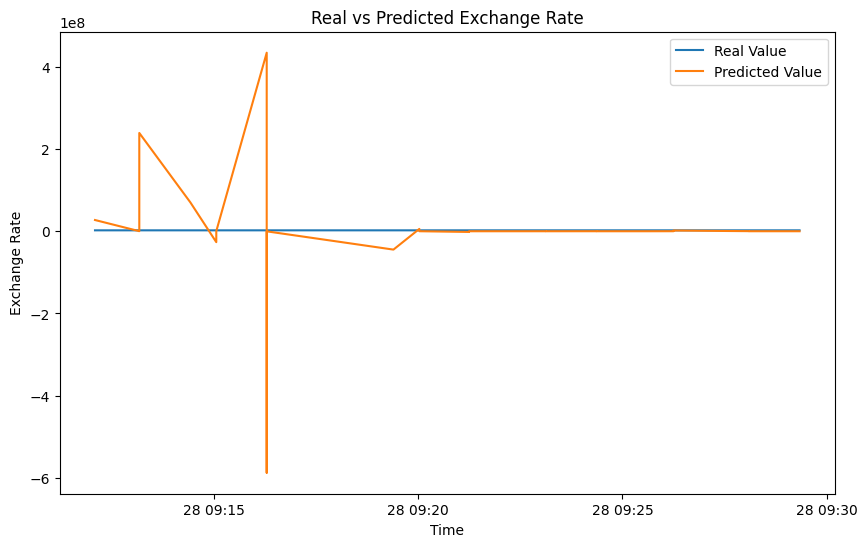

1/1 [==============================] - 0s 40ms/step
prediction [[1072.5046]]
                       real_value  predicted_value
2023-05-28 09:12:06  2.245248e+06     2.736371e+07
2023-05-28 09:13:11  2.245358e+06     1.863209e+05
2023-05-28 09:13:11  2.245358e+06     2.393406e+08
2023-05-28 09:14:26  2.245402e+06     7.015523e+07
2023-05-28 09:15:04  2.245402e+06    -2.655323e+07
2023-05-28 09:15:04  2.245402e+06     2.325624e+05
2023-05-28 09:16:18  2.245070e+06     4.347167e+08
2023-05-28 09:16:18  2.245070e+06    -5.879544e+08
2023-05-28 09:16:18  2.245070e+06    -1.127427e+08
2023-05-28 09:16:18  2.245070e+06    -9.638357e+05
2023-05-28 09:16:18  2.245070e+06    -1.983653e+05
2023-05-28 09:19:24  2.244300e+06    -4.467251e+07
2023-05-28 09:20:02  2.244184e+06     5.725932e+06
2023-05-28 09:20:02  2.244184e+06     5.708693e+04
2023-05-28 09:21:15  2.244041e+06    -1.666982e+06
2023-05-28 09:21:15  2.244041e+06    -6.826408e+02
2023-05-28 09:22:29  2.244525e+06     1.017862e+04
2023-

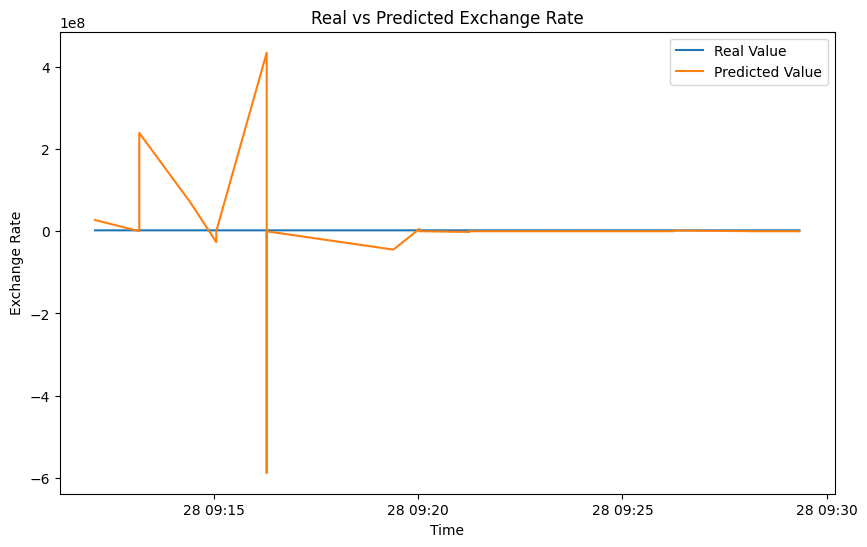

1/1 [==============================] - 0s 40ms/step
prediction [[-362.4627]]
                       real_value  predicted_value
2023-05-28 09:12:06  2.245248e+06     2.736371e+07
2023-05-28 09:13:11  2.245358e+06     1.863209e+05
2023-05-28 09:13:11  2.245358e+06     2.393406e+08
2023-05-28 09:14:26  2.245402e+06     7.015523e+07
2023-05-28 09:15:04  2.245402e+06    -2.655323e+07
2023-05-28 09:15:04  2.245402e+06     2.325624e+05
2023-05-28 09:16:18  2.245070e+06     4.347167e+08
2023-05-28 09:16:18  2.245070e+06    -5.879544e+08
2023-05-28 09:16:18  2.245070e+06    -1.127427e+08
2023-05-28 09:16:18  2.245070e+06    -9.638357e+05
2023-05-28 09:16:18  2.245070e+06    -1.983653e+05
2023-05-28 09:19:24  2.244300e+06    -4.467251e+07
2023-05-28 09:20:02  2.244184e+06     5.725932e+06
2023-05-28 09:20:02  2.244184e+06     5.708693e+04
2023-05-28 09:21:15  2.244041e+06    -1.666982e+06
2023-05-28 09:21:15  2.244041e+06    -6.826408e+02
2023-05-28 09:22:29  2.244525e+06     1.017862e+04
2023-

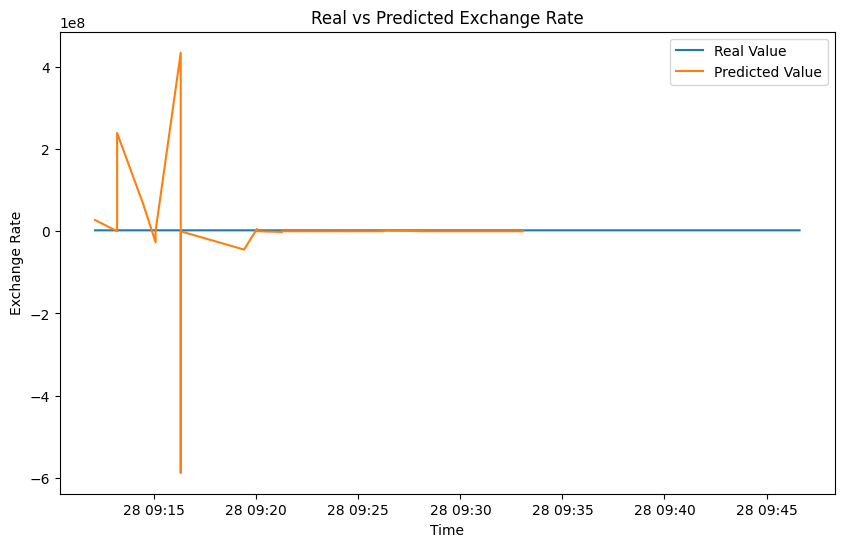

1/1 [==============================] - 0s 41ms/step
prediction [[nan]]
                       real_value  predicted_value
2023-05-28 09:12:06  2.245248e+06     2.736371e+07
2023-05-28 09:13:11  2.245358e+06     1.863209e+05
2023-05-28 09:13:11  2.245358e+06     2.393406e+08
2023-05-28 09:14:26  2.245402e+06     7.015523e+07
2023-05-28 09:15:04  2.245402e+06    -2.655323e+07
2023-05-28 09:15:04  2.245402e+06     2.325624e+05
2023-05-28 09:16:18  2.245070e+06     4.347167e+08
2023-05-28 09:16:18  2.245070e+06    -5.879544e+08
2023-05-28 09:16:18  2.245070e+06    -1.127427e+08
2023-05-28 09:16:18  2.245070e+06    -9.638357e+05
2023-05-28 09:16:18  2.245070e+06    -1.983653e+05
2023-05-28 09:19:24  2.244300e+06    -4.467251e+07
2023-05-28 09:20:02  2.244184e+06     5.725932e+06
2023-05-28 09:20:02  2.244184e+06     5.708693e+04
2023-05-28 09:21:15  2.244041e+06    -1.666982e+06
2023-05-28 09:21:15  2.244041e+06    -6.826408e+02
2023-05-28 09:22:29  2.244525e+06     1.017862e+04
2023-05-28 

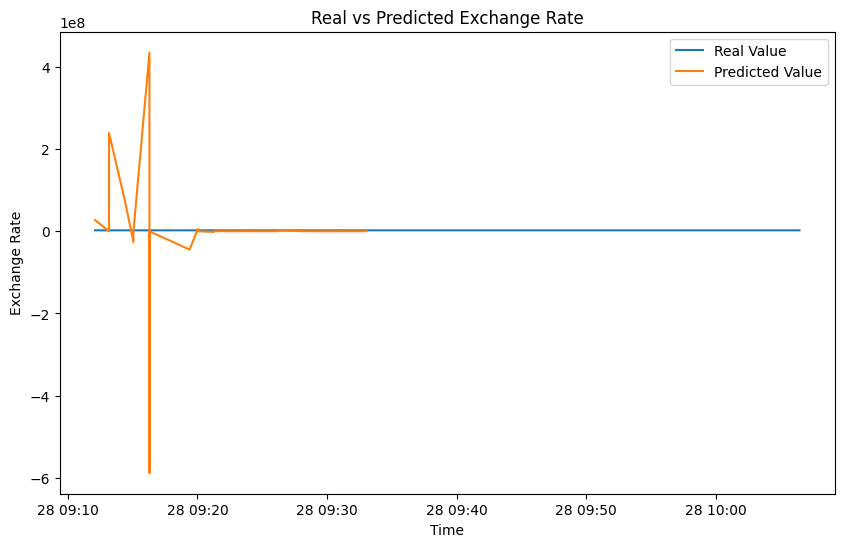

1/1 [==============================] - 0s 41ms/step
prediction [[nan]]
                       real_value  predicted_value
2023-05-28 09:12:06  2.245248e+06     2.736371e+07
2023-05-28 09:13:11  2.245358e+06     1.863209e+05
2023-05-28 09:13:11  2.245358e+06     2.393406e+08
2023-05-28 09:14:26  2.245402e+06     7.015523e+07
2023-05-28 09:15:04  2.245402e+06    -2.655323e+07
...                           ...              ...
2023-05-28 10:04:00  2.242282e+06              NaN
2023-05-28 10:05:13  2.242026e+06              NaN
2023-05-28 10:05:13  2.242026e+06              NaN
2023-05-28 10:06:27  2.241907e+06              NaN
2023-05-28 10:07:06  2.241908e+06              NaN

[89 rows x 2 columns]
1/1 [==============================] - 0s 41ms/step
prediction [[nan]]
                       real_value  predicted_value
2023-05-28 09:12:06  2.245248e+06     2.736371e+07
2023-05-28 09:13:11  2.245358e+06     1.863209e+05
2023-05-28 09:13:11  2.245358e+06     2.393406e+08
2023-05-28 09:14:26

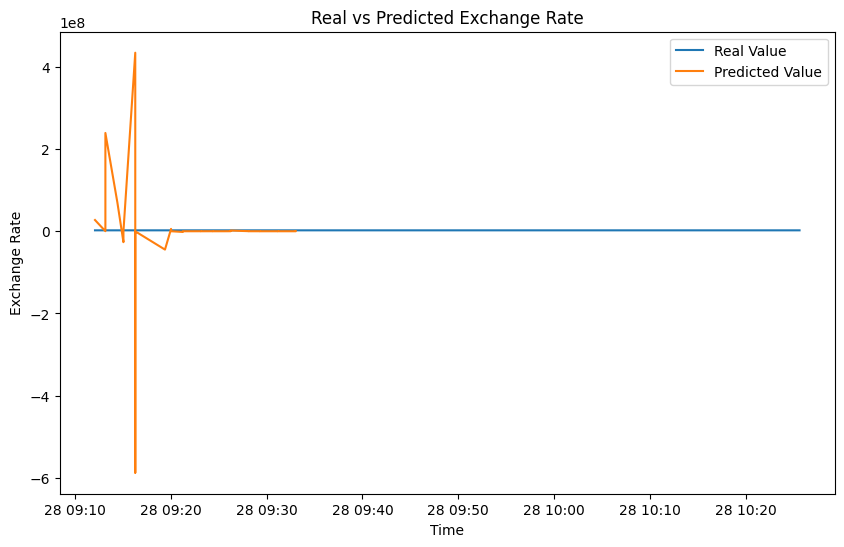

1/1 [==============================] - 0s 40ms/step
prediction [[nan]]
                       real_value  predicted_value
2023-05-28 09:12:06  2.245248e+06     2.736371e+07
2023-05-28 09:13:11  2.245358e+06     1.863209e+05
2023-05-28 09:13:11  2.245358e+06     2.393406e+08
2023-05-28 09:14:26  2.245402e+06     7.015523e+07
2023-05-28 09:15:04  2.245402e+06    -2.655323e+07
...                           ...              ...
2023-05-28 10:23:09  2.243155e+06              NaN
2023-05-28 10:24:09  2.243083e+06              NaN
2023-05-28 10:24:09  2.243083e+06              NaN
2023-05-28 10:25:36  2.243063e+06              NaN
2023-05-28 10:26:13  2.243059e+06              NaN

[120 rows x 2 columns]
1/1 [==============================] - 0s 58ms/step
prediction [[nan]]
                       real_value  predicted_value
2023-05-28 09:12:06  2.245248e+06     2.736371e+07
2023-05-28 09:13:11  2.245358e+06     1.863209e+05
2023-05-28 09:13:11  2.245358e+06     2.393406e+08
2023-05-28 09:14:2

KeyboardInterrupt: ignored

In [ ]:

import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Attention, BatchNormalization, AlphaDropout, Dense
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import selu
BASE_URL = 'https://www.alphavantage.co/query?'
API_KEY = 'K37TOUDE2WB29LQJ'
SYMBOL = 'BTCINR'  # Example forex exchange symbol
BATCH_SIZE =16
epoch=2
# NUM_FEATURES = 3
n_features=3
n_steps=5
TIME_DELAY = 35  # Time delay in seconds

def get_forex_exchange(symbol):
    params = {
        'function': 'CURRENCY_EXCHANGE_RATE',
        'from_currency': symbol[:3],
        'to_currency': symbol[3:],
        'apikey': API_KEY
    }

    try:
        response = requests.get(BASE_URL, params=params)
        data = response.json()

        forex_exchange = pd.DataFrame({
            'exchange_rate': float(data['Realtime Currency Exchange Rate']['5. Exchange Rate']),
            'bid_price': float(data['Realtime Currency Exchange Rate']['8. Bid Price']),
            'ask_price': float(data['Realtime Currency Exchange Rate']['9. Ask Price'])
        }, index=[pd.to_datetime(data['Realtime Currency Exchange Rate']['6. Last Refreshed'])])
        forex_exchange.index.name = 'time'

        return forex_exchange
    except Exception as e:
        print(f'Error fetching forex exchange details: {e}')
        return pd.DataFrame()

def create_lstm_model(n_steps, n_features):
    input_layer = Input(shape=(n_steps, n_features))
    x = Bidirectional(LSTM(units=128, return_sequences=True, use_bias=True, activation="linear",kernel_initializer='lecun_normal'))(input_layer)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    
    for i in range(5):
        x = Bidirectional(LSTM(units=256, use_bias=True, return_sequences=True, dropout=0.5, activation="linear",kernel_initializer='lecun_normal'))(x)
        x = Attention()([x, x])
        x = BatchNormalization()(x)
        # x = AlphaDropout(0.1)(x)

    x = Bidirectional(LSTM(units=128, return_sequences=False, use_bias=True, dropout=0.25, activation="linear",kernel_initializer='lecun_normal'))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    # x = AlphaDropout(0.1)(x)

    x = Dense(units=1, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=x)
    optimizer = Adam(0.01,clipnorm=0.01)
    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['accuracy',RootMeanSquaredError()])
    model.summary()
    return model

def splitsequence(data, n_steps, n_features):

    # Declare X and y as empty list
    X = []
    y = []
    for i in np.arange(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i, :])
        y.append(data['exchange_rate'][i])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    return X, y

# Create an empty DataFrame
df = pd.DataFrame(columns=['exchange_rate', 'bid_price', 'ask_price'])

model = create_lstm_model(n_steps,n_features)

predictions_df = pd.DataFrame(columns=['real_value', 'predicted_value'])

while True:
    forex_exchange = get_forex_exchange(SYMBOL)
    if not forex_exchange.empty:
        df = pd.concat([df, forex_exchange]).drop_duplicates()
        num_samples = df.shape[0]
    if num_samples > BATCH_SIZE:
        start_index = num_samples - BATCH_SIZE
        end_index = num_samples
       
        features,labels= splitsequence(df.iloc[start_index-1:,:],n_steps,n_features)
      
        for _ in range(epoch):
          model.train_on_batch(features, labels)

        x_=features[-1].reshape(1,n_steps,n_features)
        predictions = model.predict(x_)
        # predictions = predictions.reshape((n_steps, 1))
        print("prediction",predictions)
        # predictions = model.predict(features[-1])
        # # predictions = predictions.reshape((n_steps, 1))
        # print("prediction",predictions)
        new_predictions = pd.DataFrame({
            # 'time': df.index[end_index-n_steps+1:end_index+1],
            'real_value': df['exchange_rate'][end_index-1],
            'predicted_value': predictions[0]
        },index=[pd.to_datetime(df.index[end_index-1])])
        
        predictions_df = pd.concat([predictions_df, new_predictions],ignore_index=False)
        print(predictions_df)
        if num_samples % BATCH_SIZE == 0:
            plt.figure(figsize=(10, 6))
            plt.plot(predictions_df.index, predictions_df['real_value'], label='Real Value')
            plt.plot(predictions_df.index, predictions_df['predicted_value'], label='Predicted Value')
            plt.xlabel('Time')
            plt.ylabel('Exchange Rate')
            plt.title('Real vs Predicted Exchange Rate')
            plt.legend()
            plt.show()


        time.sleep(TIME_DELAY)
    else:
        time.sleep(30)

# 

In [ ]:
predictions_df = pd.concat([predictions_df, new_predictions],ignore_index=False)
print(predictions_df)

                       real_value  predicted_value
2023-05-25 22:11:16  2.189754e+06      -17686556.0
2023-05-25 22:12:20  2.189634e+06       26203556.0
2023-05-25 22:12:20  2.189634e+06      -33479152.0
2023-05-25 22:12:20  2.189634e+06      -33441460.0


In [ ]:
x_

array([[[2189679.48343188, 2189678.65595241, 2189679.48343188],
        [2189753.95658418, 2189753.12910471, 2189753.95658418]]])

In [ ]:
x_=features[-1].reshape(1,n_steps,n_features)
predictions = model.predict(x_)
# predictions = predictions.reshape((n_steps, 1))
print("prediction",predictions)

1/1 [==============================] - 0s 58ms/step
prediction [[-33441460.]]


In [ ]:
x[0]=predictions

In [ ]:
x

array([[-33441460.]], dtype=float32)

In [ ]:
new_predictions = pd.DataFrame({
            # 'time': df.index[end_index-n_steps+1:end_index+1],
            'real_value': df['exchange_rate'][end_index-1],
            'predicted_value': predictions[-1]
        },index=[pd.to_datetime(df.index[end_index-1])])

In [ ]:
new_predictions

,real_value,predicted_value
2023-05-25 22:12:20,2.189634e+06,-33441460.0


the final model for this notebook


In [5]:

import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, Attention, BatchNormalization, AlphaDropout, Dense
from keras.losses import mean_squared_error
from keras.metrics import RootMeanSquaredError
from keras.initializers import RandomUniform
from keras.optimizers import Adam
from keras.activations import selu

In [8]:
def get_forex_exchange(symbol):
    params = {
        'function': 'CURRENCY_EXCHANGE_RATE',
        'from_currency': symbol[:3],
        'to_currency': symbol[3:],
        'apikey': API_KEY
    }

    try:
        response = requests.get(BASE_URL, params=params)
        data = response.json()

        forex_exchange = pd.DataFrame({
            'exchange_rate': float(data['Realtime Currency Exchange Rate']['5. Exchange Rate']),
            'bid_price': float(data['Realtime Currency Exchange Rate']['8. Bid Price']),
            'ask_price': float(data['Realtime Currency Exchange Rate']['9. Ask Price'])
        }, index=[pd.to_datetime(data['Realtime Currency Exchange Rate']['6. Last Refreshed'])])
        forex_exchange.index.name = 'time'

        return forex_exchange
    except Exception as e:
        print(f'Error fetching forex exchange details: {e}')
        return pd.DataFrame()

In [9]:
def create_lstm_model(n_steps, n_features):
    input_layer = Input(shape=(n_steps, n_features))
    # x= Dense()
    x = Bidirectional(LSTM(units=128, return_sequences=True, use_bias=True, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(input_layer)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    
    # for i in range():
    x = Bidirectional(LSTM(units=256, use_bias=True, return_sequences=True, dropout=0.5, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    # x = AlphaDropout(0.1)(x)
    x = Bidirectional(LSTM(units=512, use_bias=True, return_sequences=True, dropout=0.25, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    x = Bidirectional(LSTM(units=512, use_bias=True, return_sequences=True, dropout=0.75, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    # x = AlphaDropout(0.1)(x)
    x = Bidirectional(LSTM(units=256, use_bias=True, return_sequences=True, dropout=0.5, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    # x = AlphaDropout(0.1)(x)

    x = Bidirectional(LSTM(units=128, return_sequences=False, use_bias=True, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    # x = AlphaDropout(0.1)(x)

    x = Dense(units=1, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=x)
    optimizer = Adam(0.001,clipnorm=0.01)
    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['accuracy',RootMeanSquaredError()])
    model.summary()
    return model

In [10]:
def splitsequence(data, n_steps, n_features):

    # Declare X and y as empty list
    X = []
    y = []
    for i in np.arange(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i, :].values)
        y.append(data['exchange_rate'][i])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    return X, y


In [11]:

def plot_(data):
  plt.figure(figsize=(10, 6))
  plt.plot(data.index, data['real_value'], label='Real Value')
  # plt.plot(data.index, data['predicted_value'], label='Predicted Value')
  plt.xlabel('Time')
  plt.ylabel('Exchange Rate')
  plt.title('Real vs Predicted Exchange Rate')
  plt.legend()
  plt.show()
  plt.figure(figsize=(10, 6))
  # plt.plot(data.index, data['real_value'], label='Real Value')
  plt.plot(data.index, data['predicted_value'], label='Predicted Value')
  plt.xlabel('Time')
  plt.ylabel('Exchange Rate')
  plt.title('Real vs Predicted Exchange Rate')
  plt.legend()
  plt.show()

In [13]:
BASE_URL = 'https://www.alphavantage.co/query?'
API_KEY = 'K37TOUDE2WB29LQJ'
SYMBOL = 'BTCINR'  # Example forex exchange symbol
BATCH_SIZE =16
epoch=2
# NUM_FEATURES = 3
n_features=3
n_steps=5
TIME_DELAY = 35  # Time delay in seconds


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 3)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 5, 256)       135168      ['input_1[0][0]']                
                                                                                                  
 attention (Attention)          (None, 5, 256)       0           ['bidirectional[0][0]',          
                                                                  'bidirectional[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 5, 256)      1024        ['attention[0][0]']          

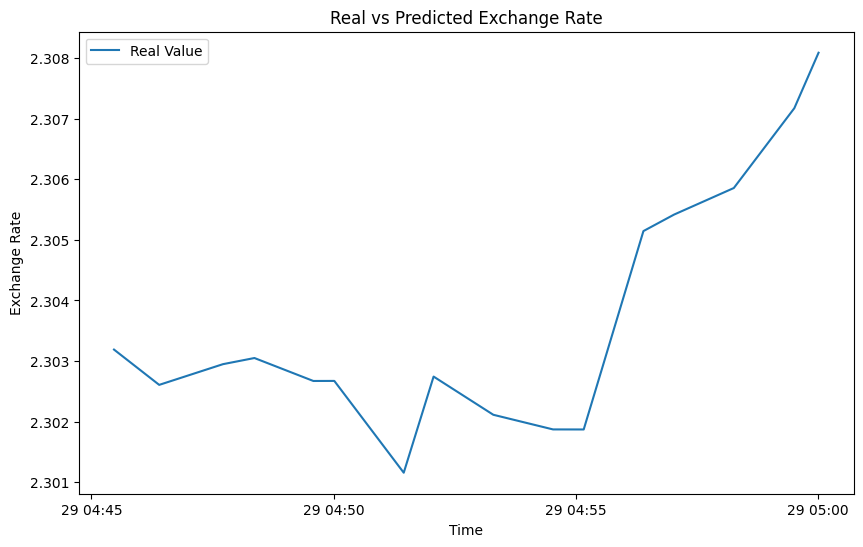

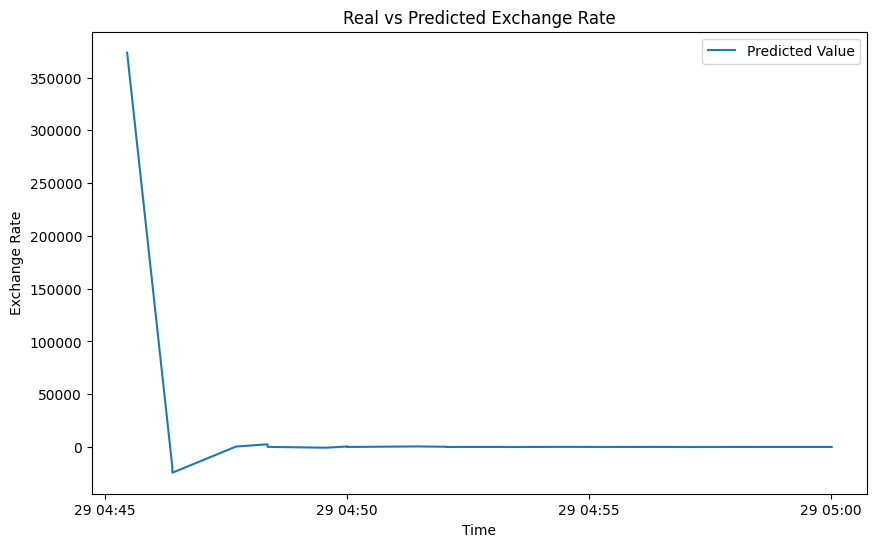

1/1 [==============================] - 0s 49ms/step
prediction [[-0.1978106]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
2023-05-29 04:48:22    2.303049        76.334854
2023-05-29 04:49:35    2.302670      -703.244568
2023-05-29 04:50:01    2.302670       468.716827
2023-05-29 04:50:01    2.302670       -12.974713
2023-05-29 04:51:27    2.301154       492.159271
2023-05-29 04:52:04    2.302742       182.064774
2023-05-29 04:52:04    2.302742       -24.233984
2023-05-29 04:53:18    2.302111        30.145252
2023-05-29 04:53:18    2.302111       -79.670532
2023-05-29 04:54:32    2.301869        91.190994
2023-05-29 04:55:10    2.301868         4.685445
2023-05-29 04:55:10    2.301868       -32.579887
2023-05-29 04:56:24    2.305146        3

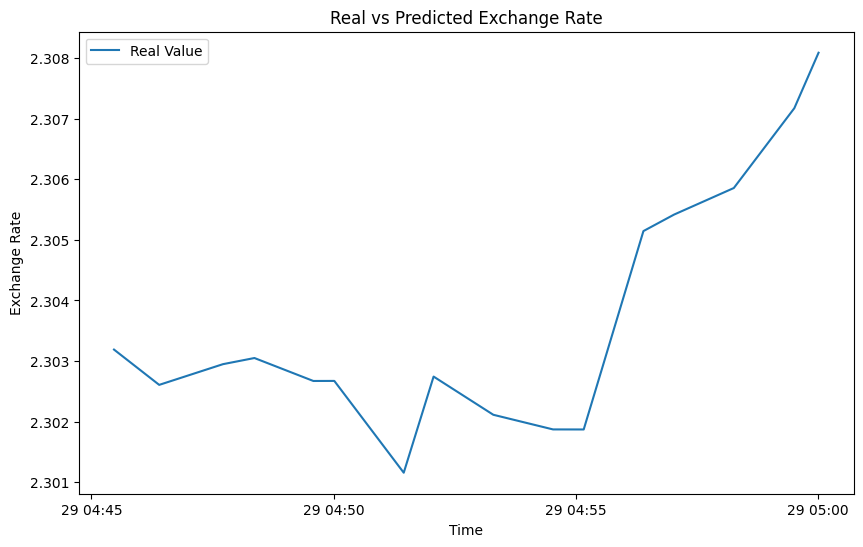

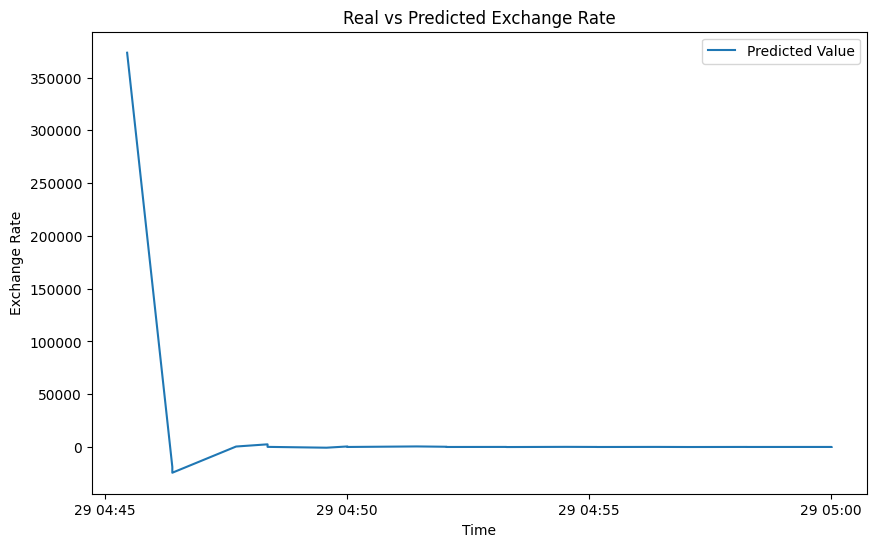

1/1 [==============================] - 0s 63ms/step
prediction [[-19.20531]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
2023-05-29 04:48:22    2.303049        76.334854
2023-05-29 04:49:35    2.302670      -703.244568
2023-05-29 04:50:01    2.302670       468.716827
2023-05-29 04:50:01    2.302670       -12.974713
2023-05-29 04:51:27    2.301154       492.159271
2023-05-29 04:52:04    2.302742       182.064774
2023-05-29 04:52:04    2.302742       -24.233984
2023-05-29 04:53:18    2.302111        30.145252
2023-05-29 04:53:18    2.302111       -79.670532
2023-05-29 04:54:32    2.301869        91.190994
2023-05-29 04:55:10    2.301868         4.685445
2023-05-29 04:55:10    2.301868       -32.579887
2023-05-29 04:56:24    2.305146        39

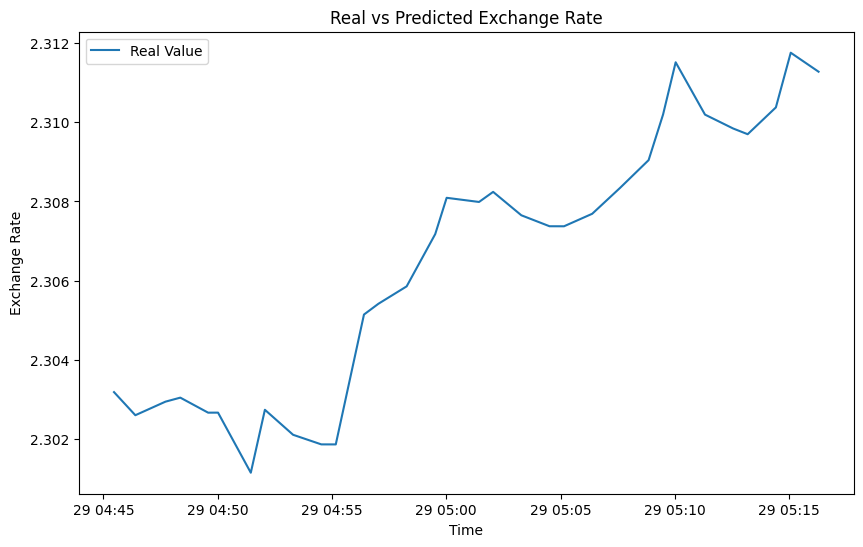

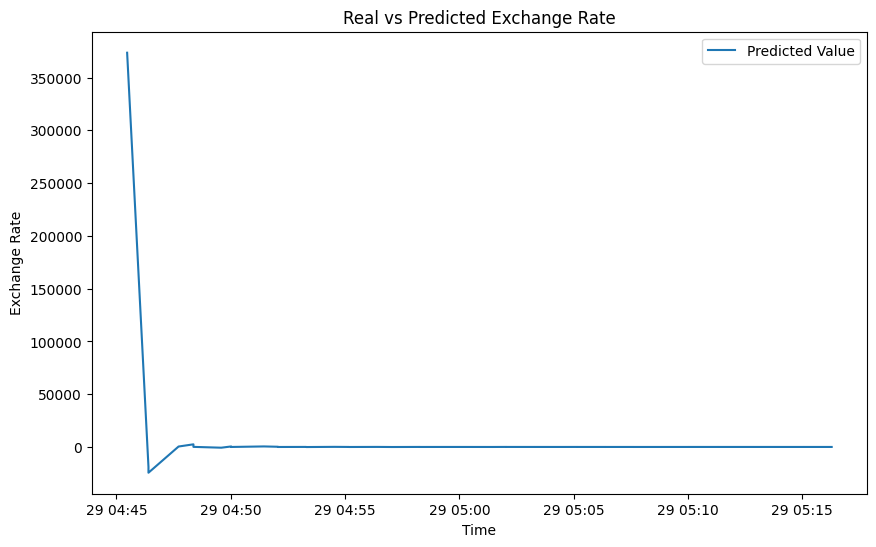

1/1 [==============================] - 0s 52ms/step
prediction [[3.8426666]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
2023-05-29 04:48:22    2.303049        76.334854
2023-05-29 04:49:35    2.302670      -703.244568
2023-05-29 04:50:01    2.302670       468.716827
2023-05-29 04:50:01    2.302670       -12.974713
2023-05-29 04:51:27    2.301154       492.159271
2023-05-29 04:52:04    2.302742       182.064774
2023-05-29 04:52:04    2.302742       -24.233984
2023-05-29 04:53:18    2.302111        30.145252
2023-05-29 04:53:18    2.302111       -79.670532
2023-05-29 04:54:32    2.301869        91.190994
2023-05-29 04:55:10    2.301868         4.685445
2023-05-29 04:55:10    2.301868       -32.579887
2023-05-29 04:56:24    2.305146        39

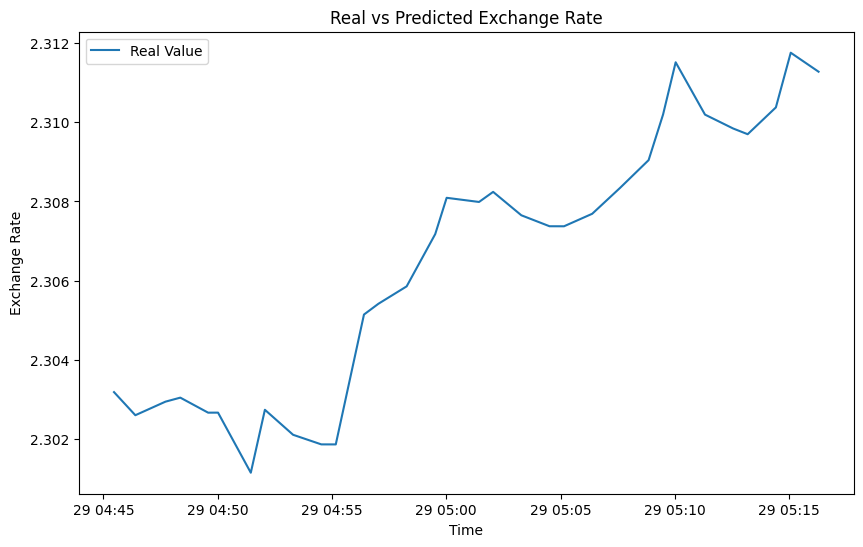

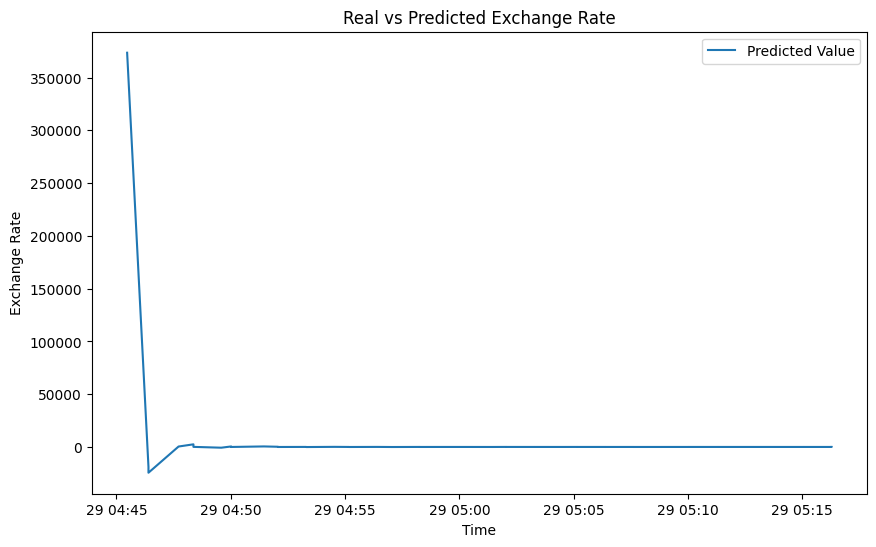

1/1 [==============================] - 0s 52ms/step
prediction [[0.33383587]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
2023-05-29 04:48:22    2.303049        76.334854
2023-05-29 04:49:35    2.302670      -703.244568
2023-05-29 04:50:01    2.302670       468.716827
2023-05-29 04:50:01    2.302670       -12.974713
2023-05-29 04:51:27    2.301154       492.159271
2023-05-29 04:52:04    2.302742       182.064774
2023-05-29 04:52:04    2.302742       -24.233984
2023-05-29 04:53:18    2.302111        30.145252
2023-05-29 04:53:18    2.302111       -79.670532
2023-05-29 04:54:32    2.301869        91.190994
2023-05-29 04:55:10    2.301868         4.685445
2023-05-29 04:55:10    2.301868       -32.579887
2023-05-29 04:56:24    2.305146        3

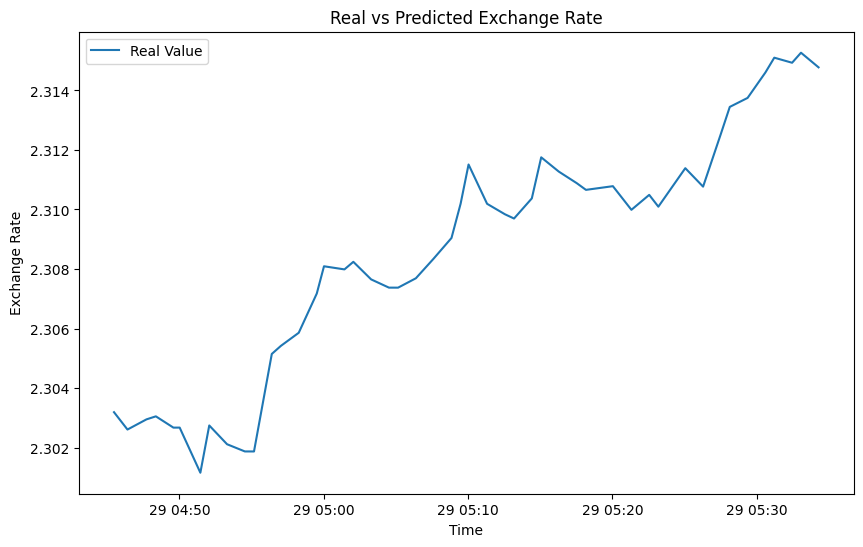

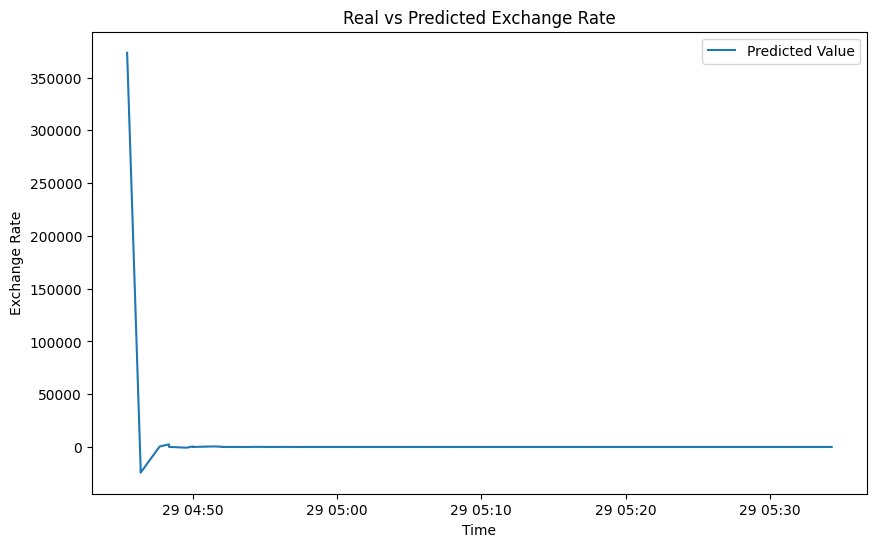

1/1 [==============================] - 0s 51ms/step
prediction [[0.66685194]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 05:32:27    2.314931         3.933874
2023-05-29 05:33:04    2.315268         5.528738
2023-05-29 05:33:04    2.315268         1.029874
2023-05-29 05:34:17    2.314776         1.986738
2023-05-29 05:34:17    2.314776         0.666852

[80 rows x 2 columns]


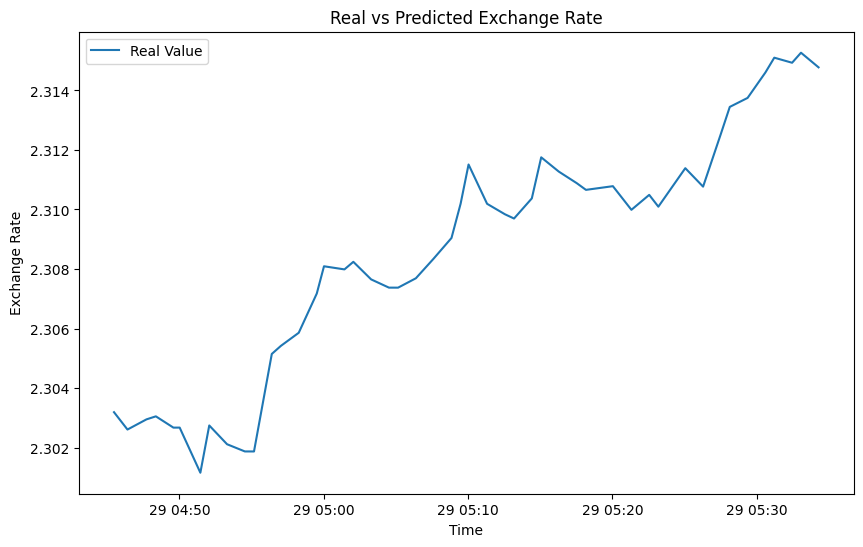

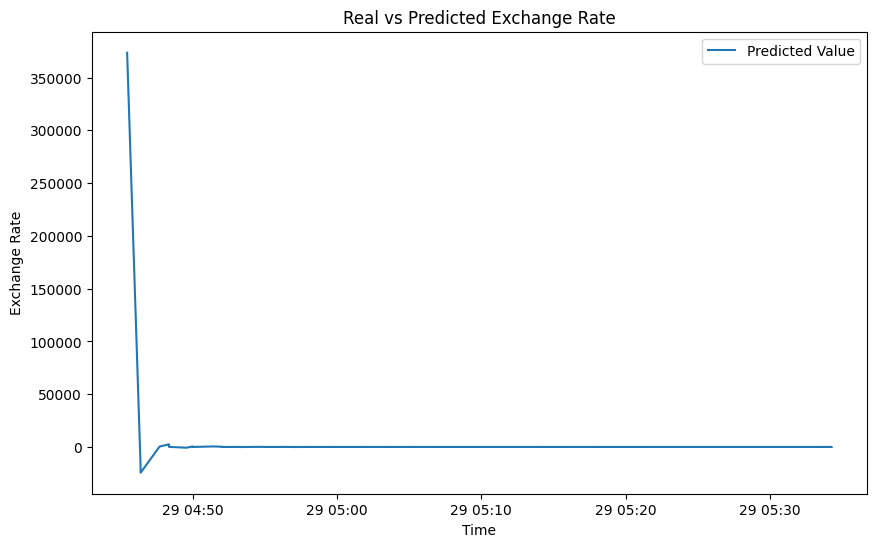

1/1 [==============================] - 0s 48ms/step
prediction [[5.0277753]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 05:33:04    2.315268         5.528738
2023-05-29 05:33:04    2.315268         1.029874
2023-05-29 05:34:17    2.314776         1.986738
2023-05-29 05:34:17    2.314776         0.666852
2023-05-29 05:34:17    2.314776         5.027775

[81 rows x 2 columns]


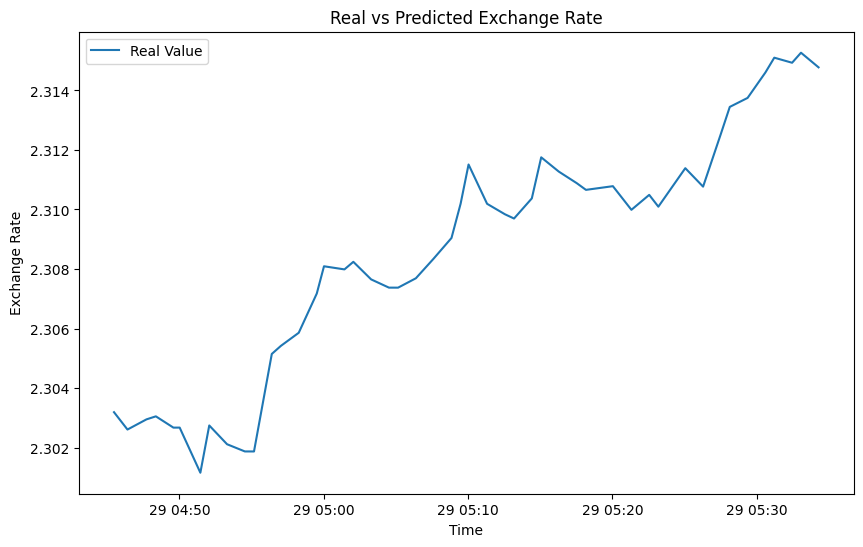

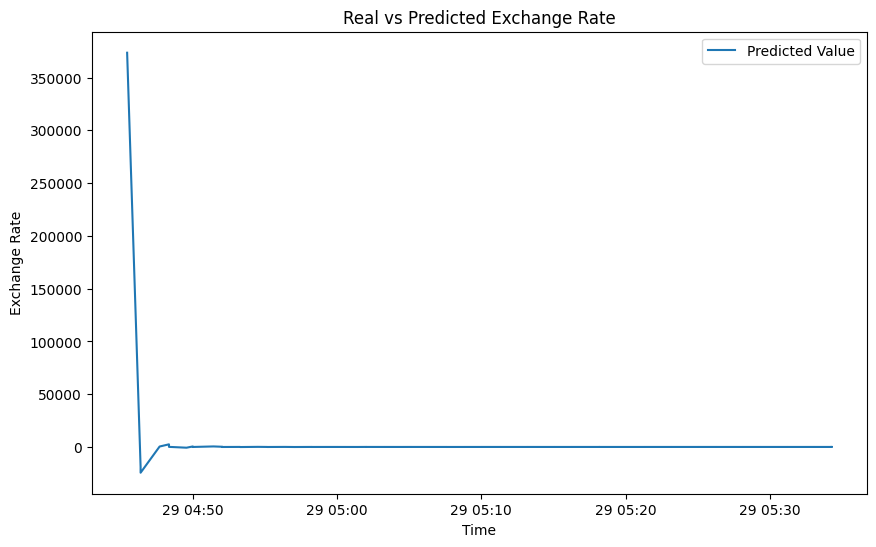

1/1 [==============================] - 0s 46ms/step
prediction [[1.8400041]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 05:33:04    2.315268         1.029874
2023-05-29 05:34:17    2.314776         1.986738
2023-05-29 05:34:17    2.314776         0.666852
2023-05-29 05:34:17    2.314776         5.027775
2023-05-29 05:36:10    2.315639         1.840004

[82 rows x 2 columns]
1/1 [==============================] - 0s 46ms/step
prediction [[1.8448188]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       4

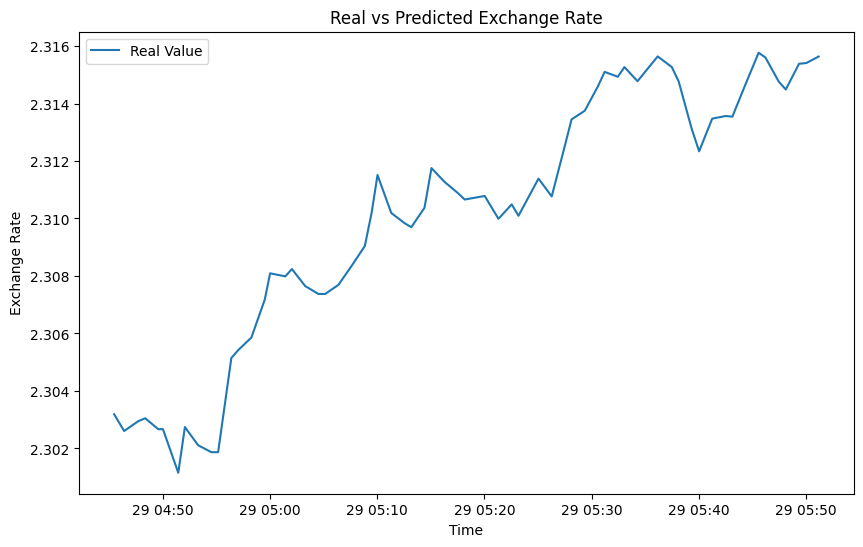

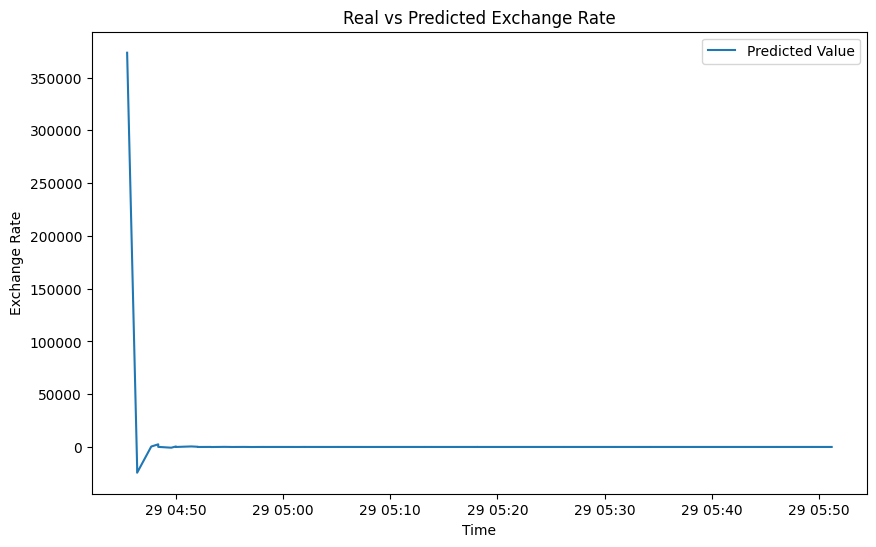

1/1 [==============================] - 0s 49ms/step
prediction [[0.65793383]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 05:49:21    2.315382         5.060029
2023-05-29 05:49:21    2.315382         4.595808
2023-05-29 05:50:02    2.315409         0.376661
2023-05-29 05:51:11    2.315635         0.344495
2023-05-29 05:51:11    2.315635         0.657934

[107 rows x 2 columns]


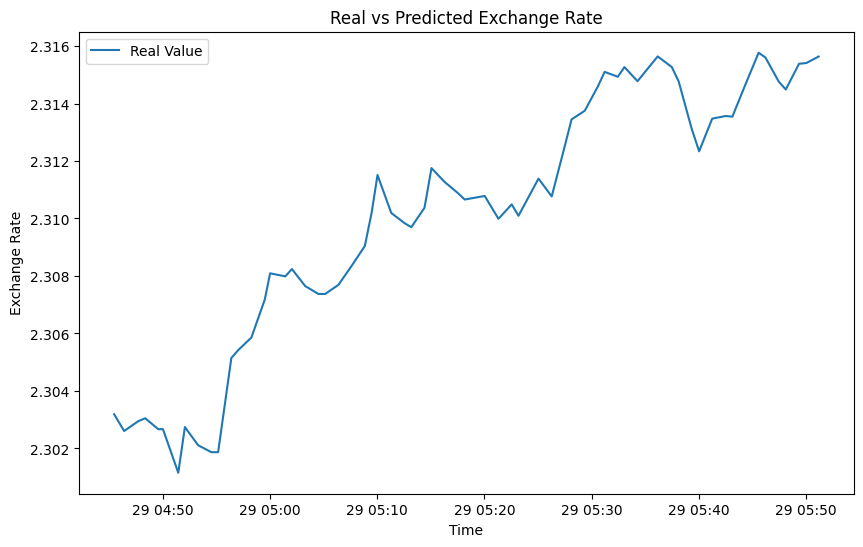

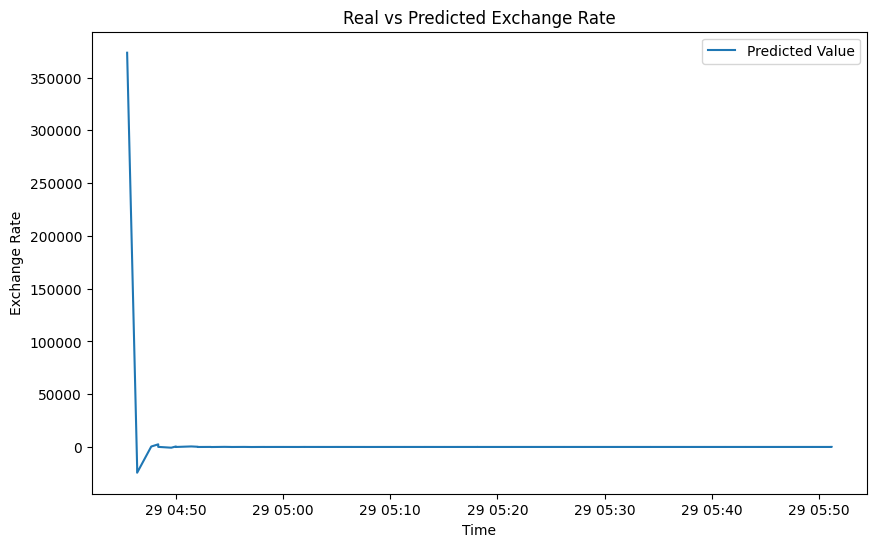

1/1 [==============================] - 0s 47ms/step
prediction [[4.298411]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 05:49:21    2.315382         4.595808
2023-05-29 05:50:02    2.315409         0.376661
2023-05-29 05:51:11    2.315635         0.344495
2023-05-29 05:51:11    2.315635         0.657934
2023-05-29 05:52:26    2.313620         4.298411

[108 rows x 2 columns]
1/1 [==============================] - 0s 49ms/step
prediction [[3.0373158]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       4

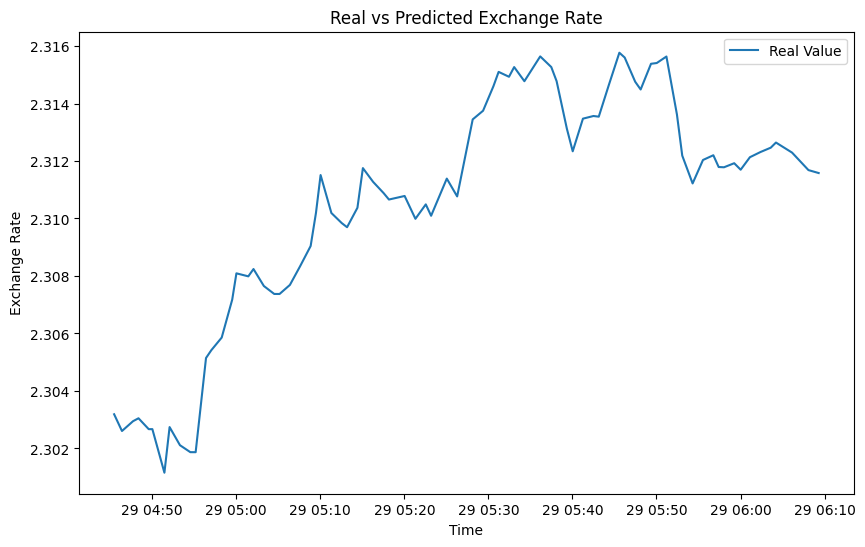

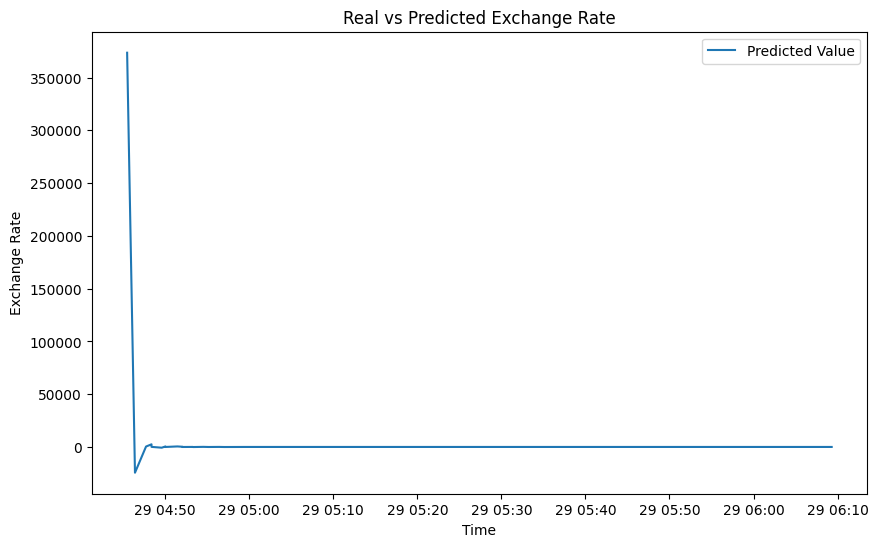

1/1 [==============================] - 0s 48ms/step
prediction [[1.0610332]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 06:06:08    2.312292         2.516291
2023-05-29 06:08:05    2.311683         2.075944
2023-05-29 06:08:05    2.311683         2.995184
2023-05-29 06:09:18    2.311581         2.767629
2023-05-29 06:09:18    2.311581         1.061033

[136 rows x 2 columns]


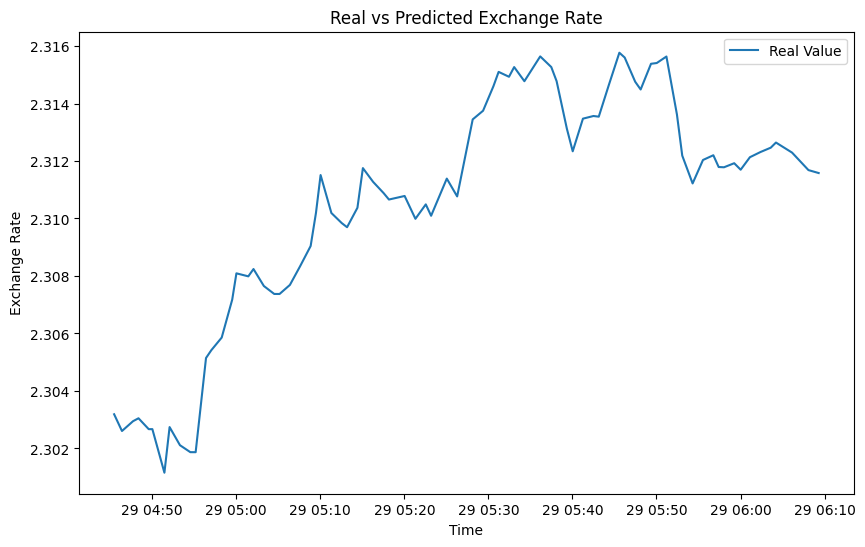

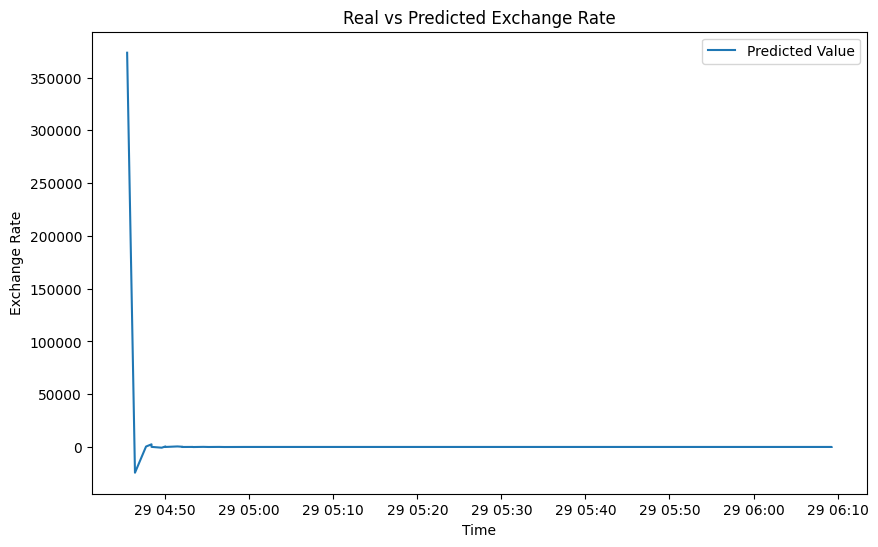

1/1 [==============================] - 0s 45ms/step
prediction [[3.1752994]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 06:08:05    2.311683         2.075944
2023-05-29 06:08:05    2.311683         2.995184
2023-05-29 06:09:18    2.311581         2.767629
2023-05-29 06:09:18    2.311581         1.061033
2023-05-29 06:10:02    2.311378         3.175299

[137 rows x 2 columns]
1/1 [==============================] - 0s 58ms/step
prediction [[1.9894294]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       

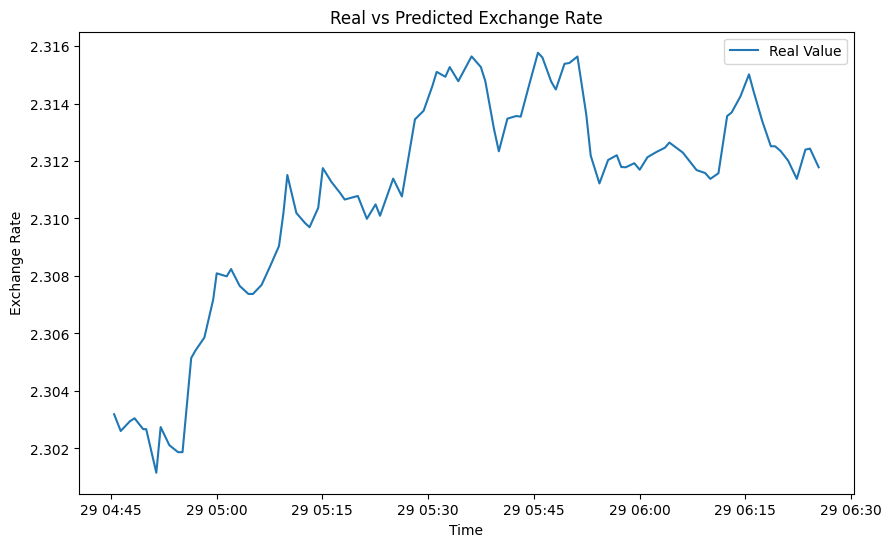

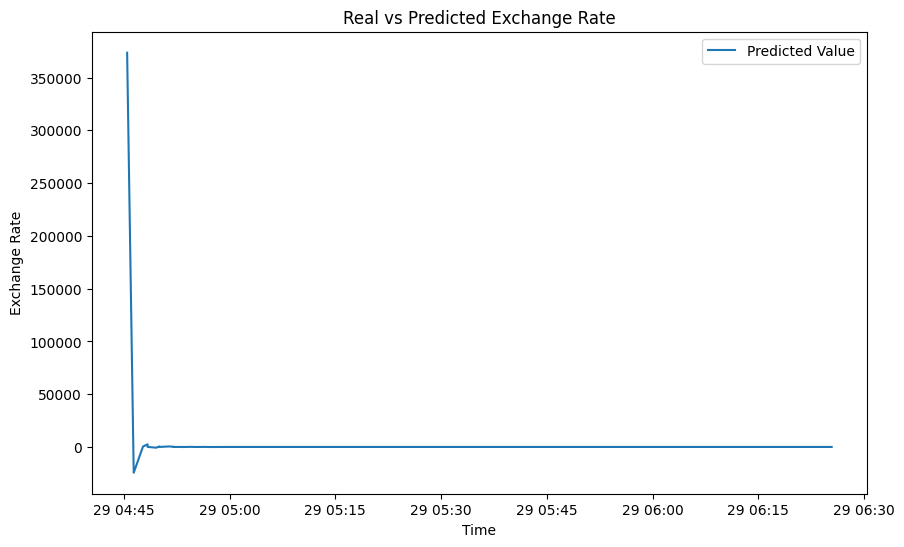

1/1 [==============================] - 0s 65ms/step
prediction [[2.0509715]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 06:23:31    2.312396         1.900146
2023-05-29 06:24:10    2.312432         2.173803
2023-05-29 06:24:10    2.312432         2.511682
2023-05-29 06:25:24    2.311781         2.348852
2023-05-29 06:26:02    2.311903         2.050972

[162 rows x 2 columns]
1/1 [==============================] - 0s 47ms/step
prediction [[2.5292974]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       

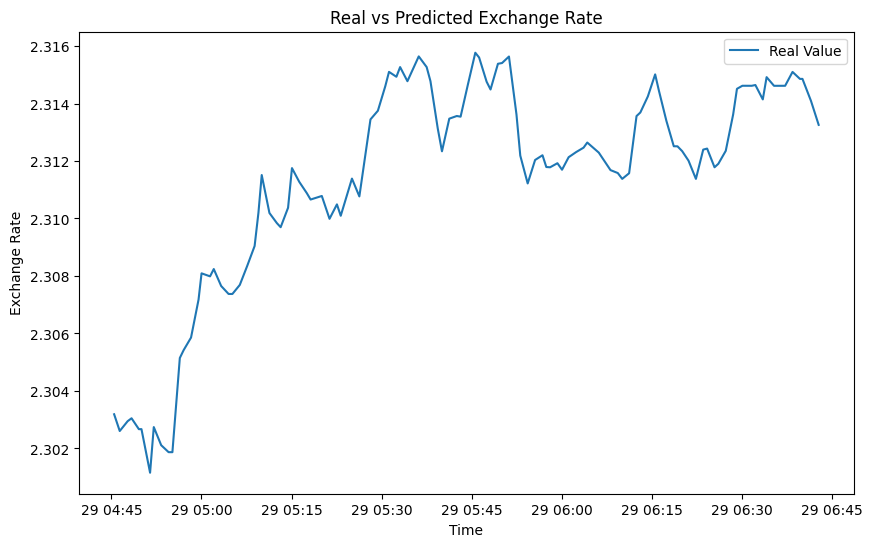

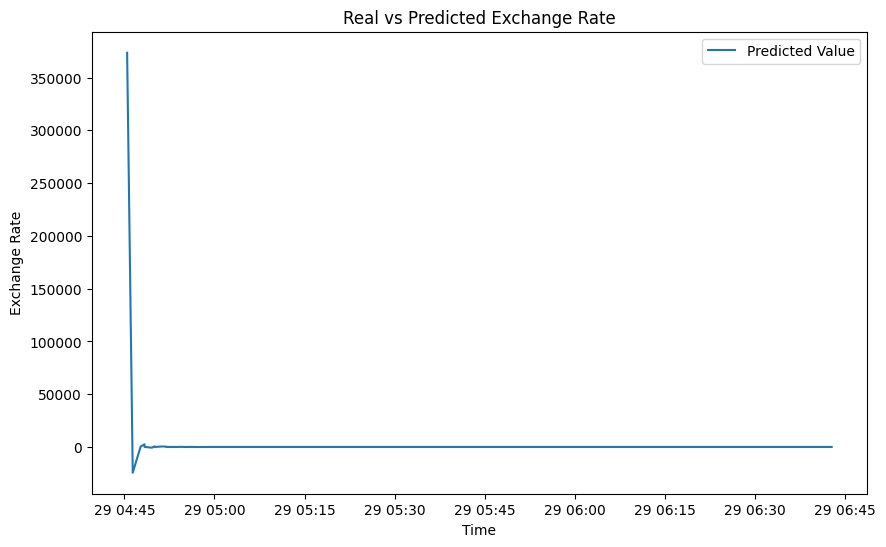

1/1 [==============================] - 0s 45ms/step
prediction [[2.213313]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 06:40:02    2.314857         2.390317
2023-05-29 06:41:27    2.314092         2.315411
2023-05-29 06:41:27    2.314092         2.428126
2023-05-29 06:42:44    2.313257         2.325355
2023-05-29 06:43:22    2.312927         2.213313

[190 rows x 2 columns]
1/1 [==============================] - 0s 47ms/step
prediction [[2.5395532]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       4

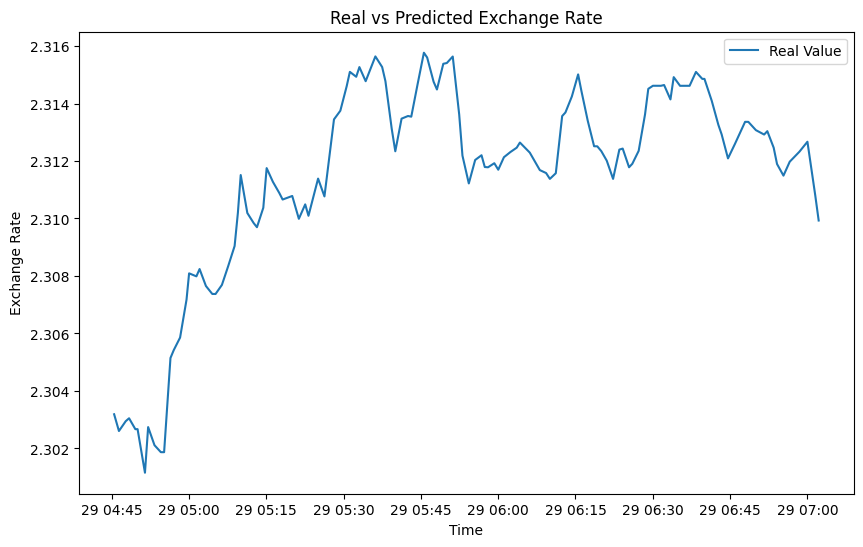

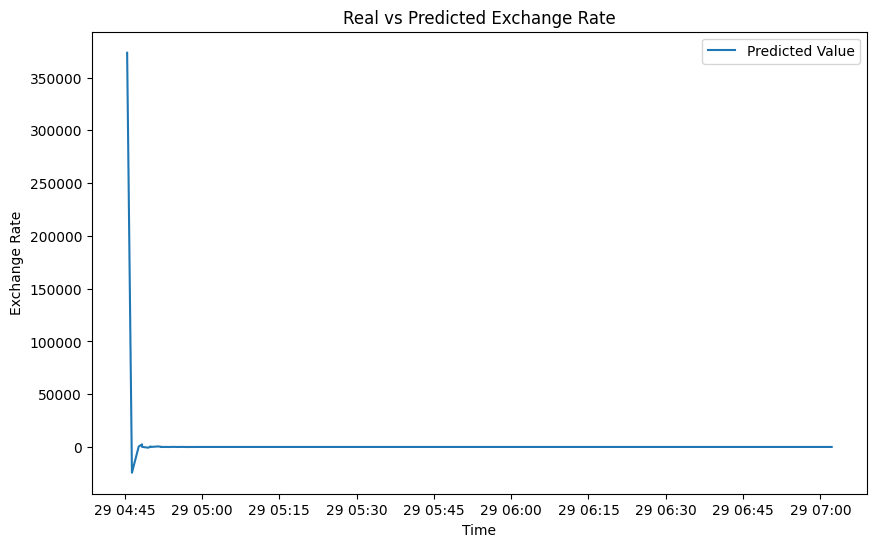

1/1 [==============================] - 0s 73ms/step
prediction [[2.0784454]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 07:00:01    2.312670         2.274490
2023-05-29 07:00:01    2.312670         2.333080
2023-05-29 07:01:32    2.310807         2.092522
2023-05-29 07:02:12    2.309929         2.424702
2023-05-29 07:02:12    2.309929         2.078445

[221 rows x 2 columns]


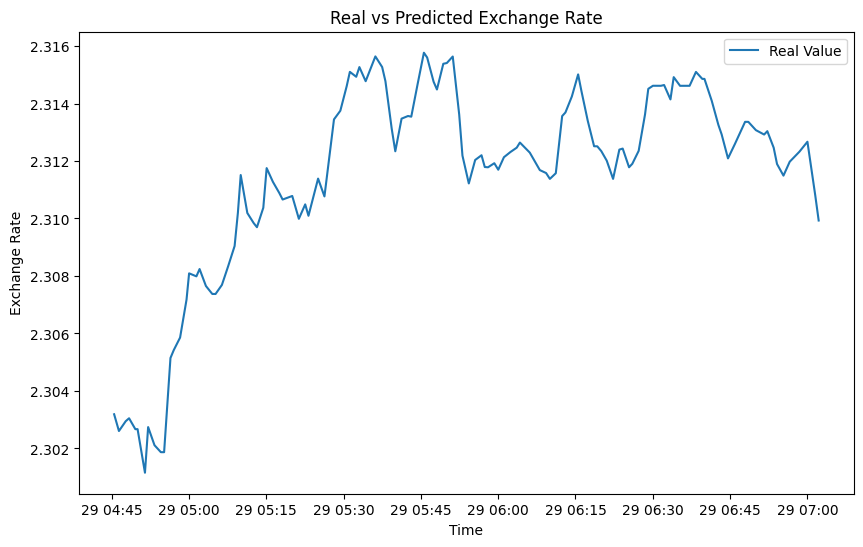

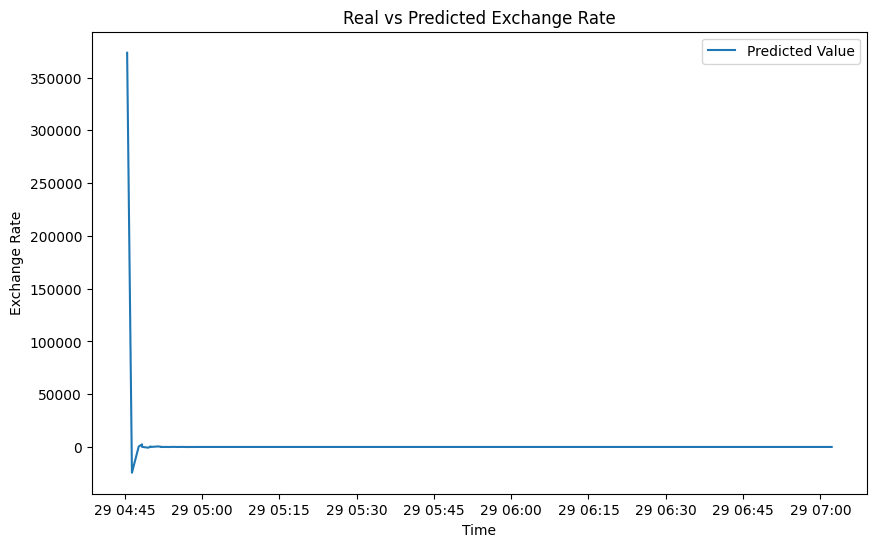

1/1 [==============================] - 0s 49ms/step
prediction [[2.421993]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 07:00:01    2.312670         2.333080
2023-05-29 07:01:32    2.310807         2.092522
2023-05-29 07:02:12    2.309929         2.424702
2023-05-29 07:02:12    2.309929         2.078445
2023-05-29 07:03:27    2.308923         2.421993

[222 rows x 2 columns]
1/1 [==============================] - 0s 51ms/step
prediction [[2.375892]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       40

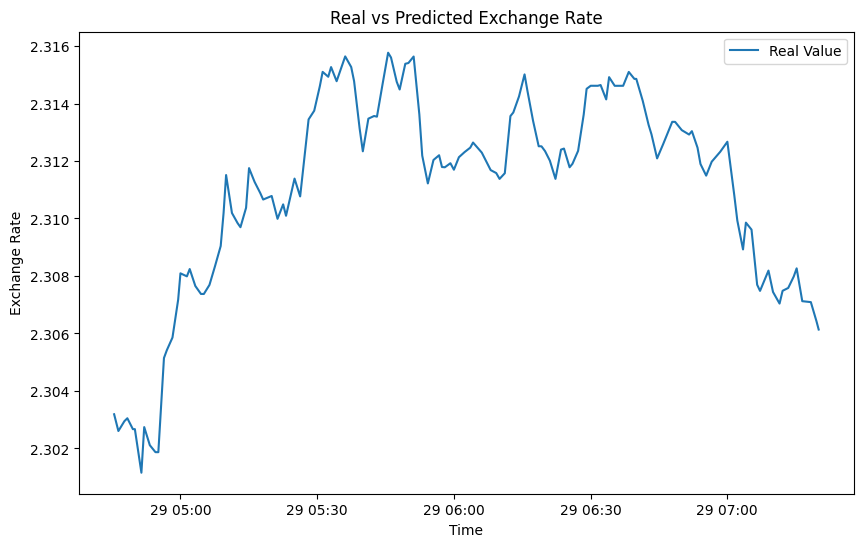

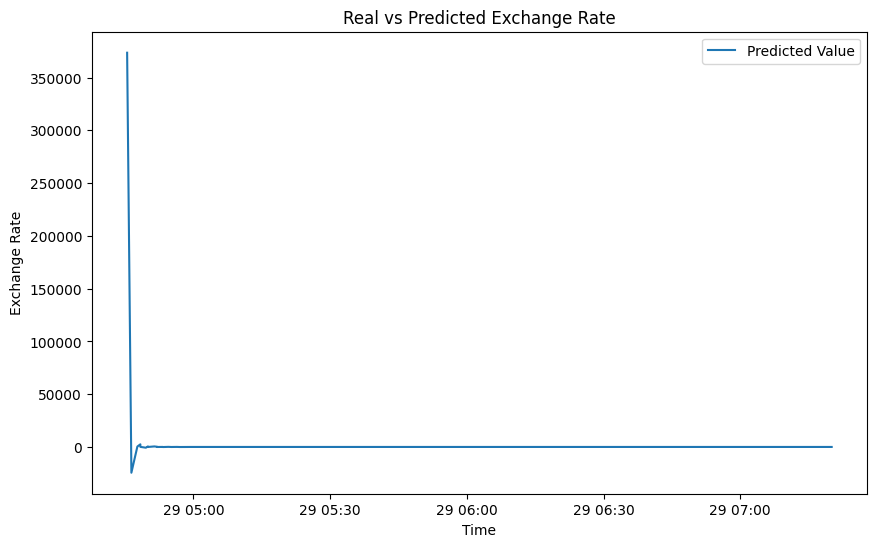

1/1 [==============================] - 0s 72ms/step
prediction [[2.5015283]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 07:18:20    2.307090         2.401519
2023-05-29 07:18:20    2.307090         2.263150
2023-05-29 07:19:34    2.306425         2.008409
2023-05-29 07:20:03    2.306136         2.014168
2023-05-29 07:20:03    2.306136         2.501528

[250 rows x 2 columns]


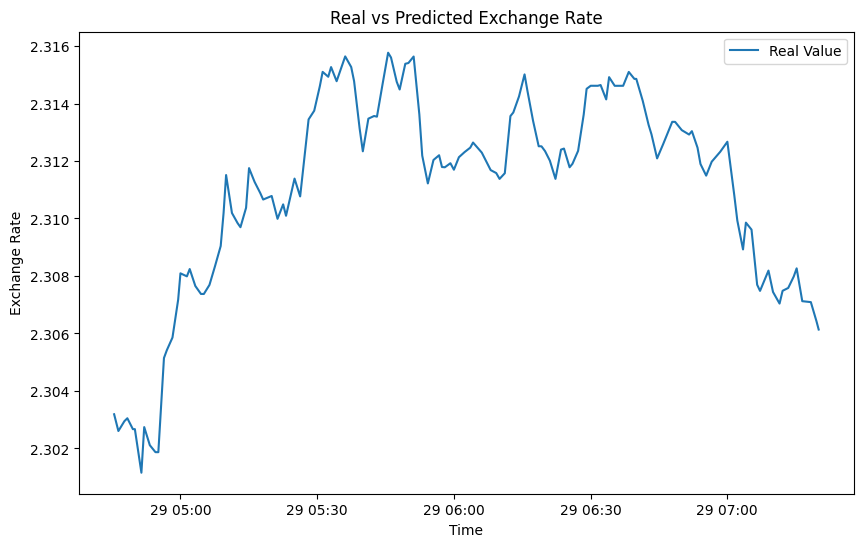

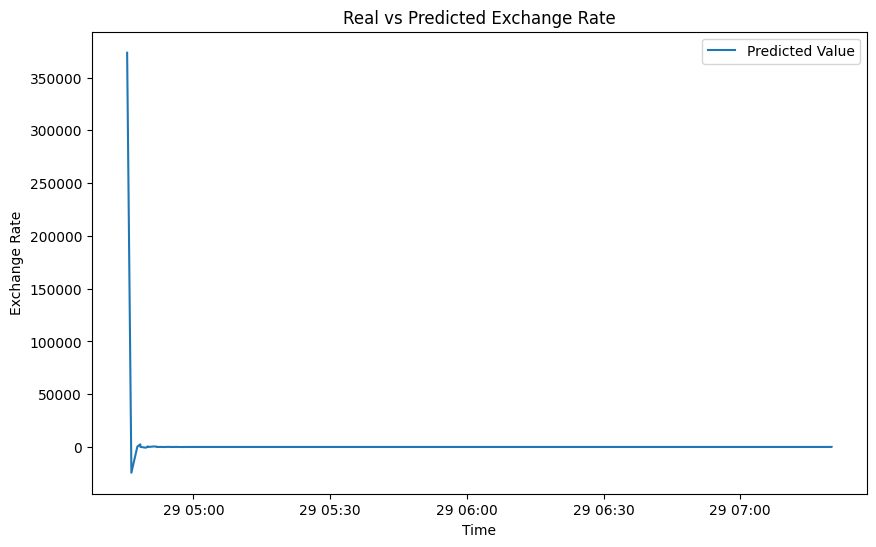

1/1 [==============================] - 0s 59ms/step
prediction [[2.2358682]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 07:18:20    2.307090         2.263150
2023-05-29 07:19:34    2.306425         2.008409
2023-05-29 07:20:03    2.306136         2.014168
2023-05-29 07:20:03    2.306136         2.501528
2023-05-29 07:21:26    2.307086         2.235868

[251 rows x 2 columns]
1/1 [==============================] - 0s 55ms/step
prediction [[2.3271143]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       

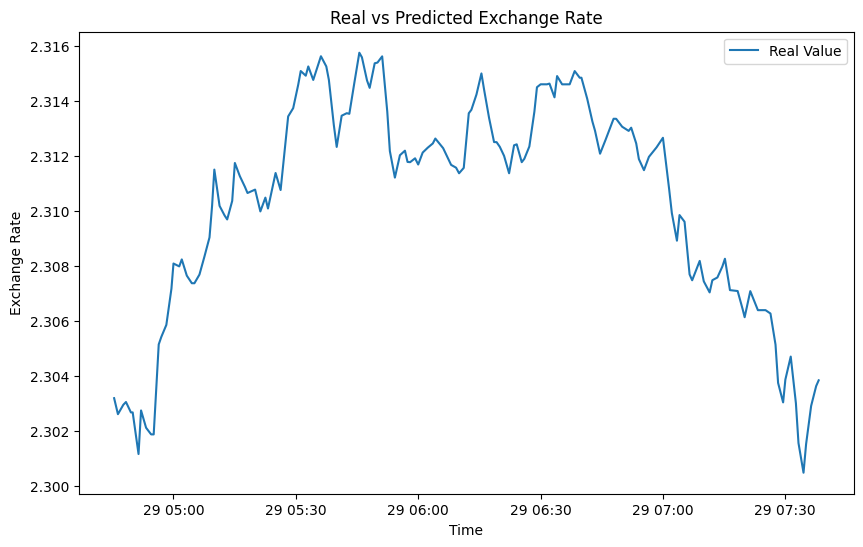

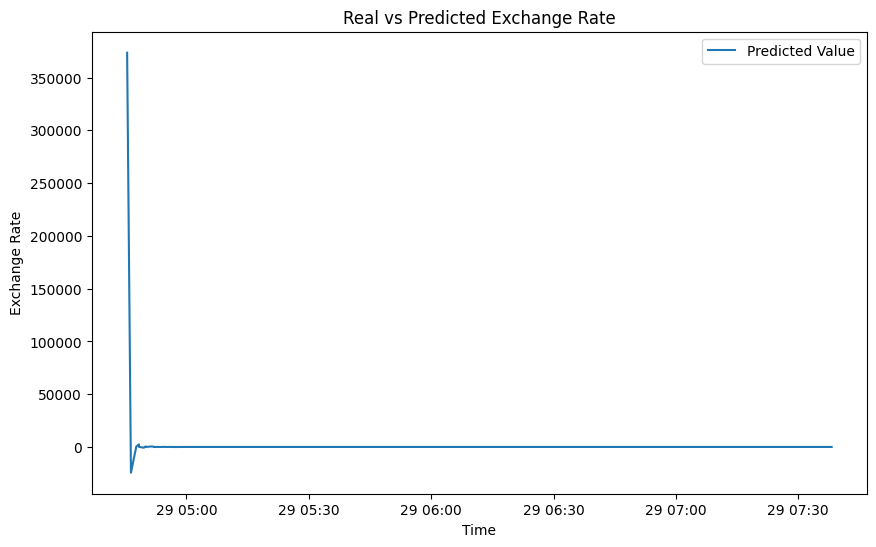

1/1 [==============================] - 0s 68ms/step
prediction [[2.363983]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 07:36:21    2.302906         2.335967
2023-05-29 07:36:21    2.302906         2.270407
2023-05-29 07:37:35    2.303629         2.307328
2023-05-29 07:38:12    2.303838         2.305811
2023-05-29 07:38:12    2.303838         2.363983

[279 rows x 2 columns]


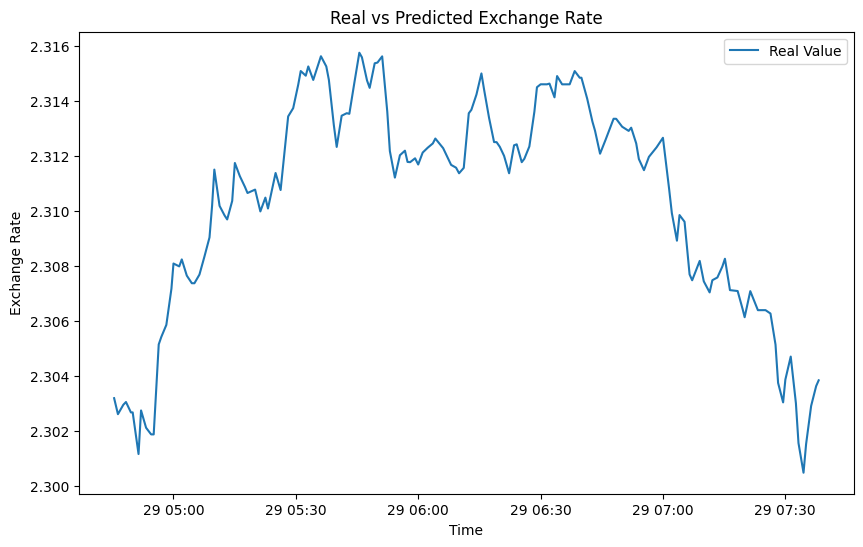

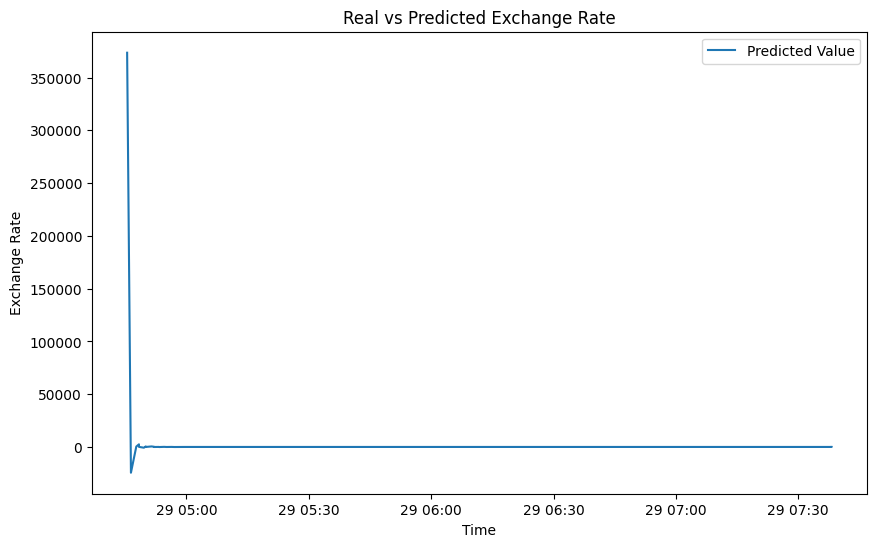

1/1 [==============================] - 0s 48ms/step
prediction [[2.3698552]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 07:36:21    2.302906         2.270407
2023-05-29 07:37:35    2.303629         2.307328
2023-05-29 07:38:12    2.303838         2.305811
2023-05-29 07:38:12    2.303838         2.363983
2023-05-29 07:39:28    2.304901         2.369855

[280 rows x 2 columns]
1/1 [==============================] - 0s 46ms/step
prediction [[2.3307104]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       

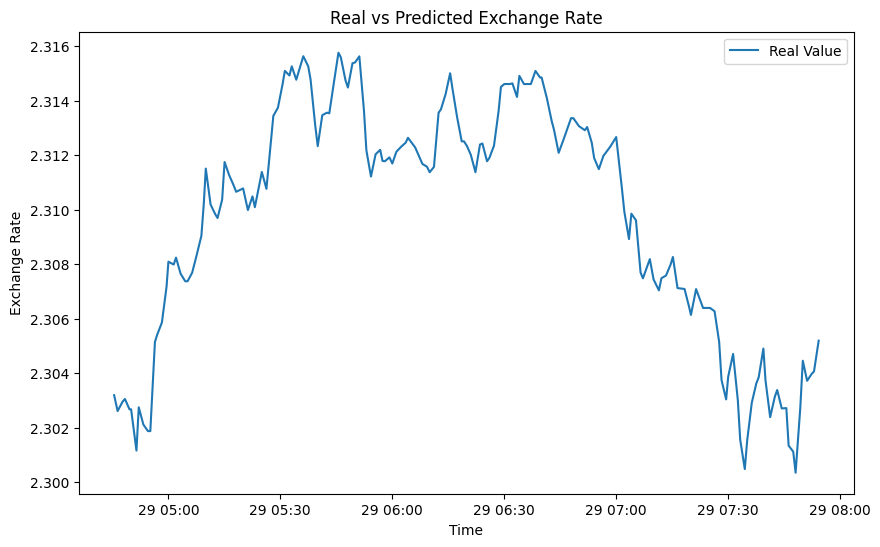

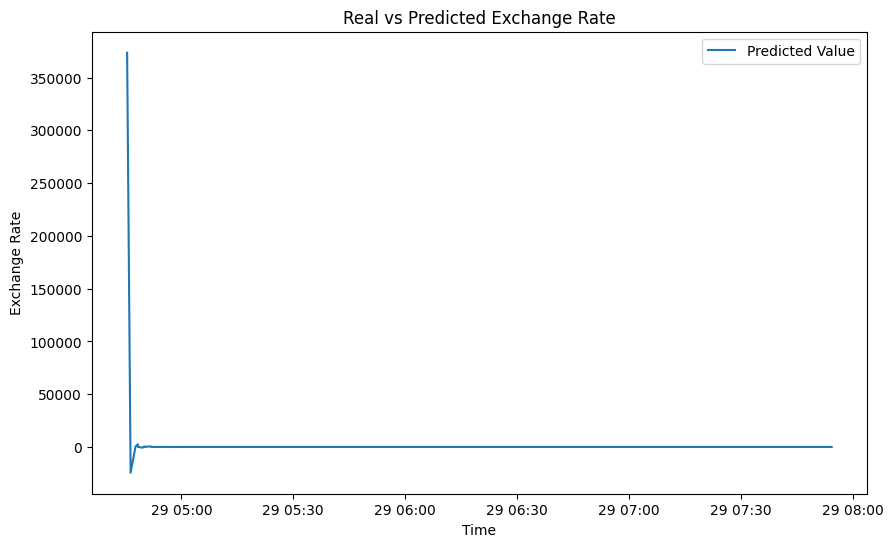

1/1 [==============================] - 0s 86ms/step
prediction [[2.2561896]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 07:52:25    2.303973         2.232890
2023-05-29 07:53:02    2.304062         2.087321
2023-05-29 07:53:02    2.304062         2.185465
2023-05-29 07:54:17    2.305192         2.244596
2023-05-29 07:54:17    2.305192         2.256190

[305 rows x 2 columns]


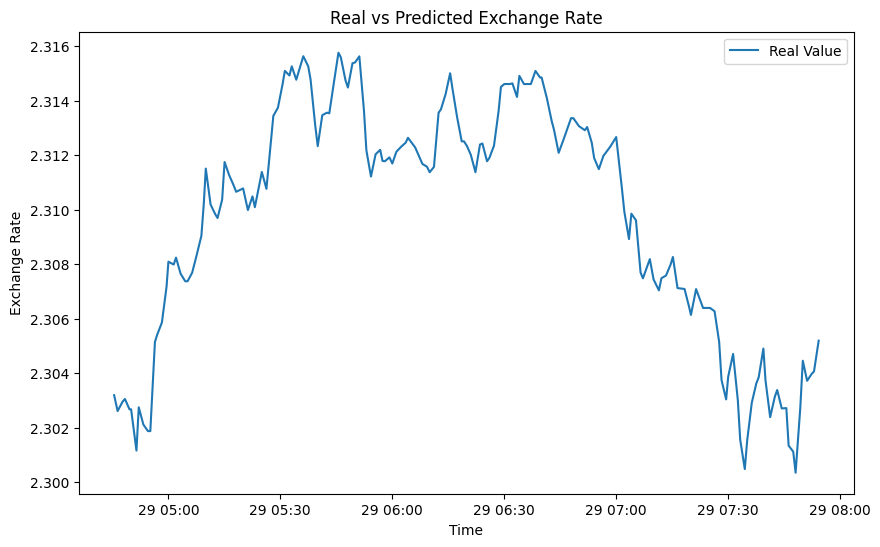

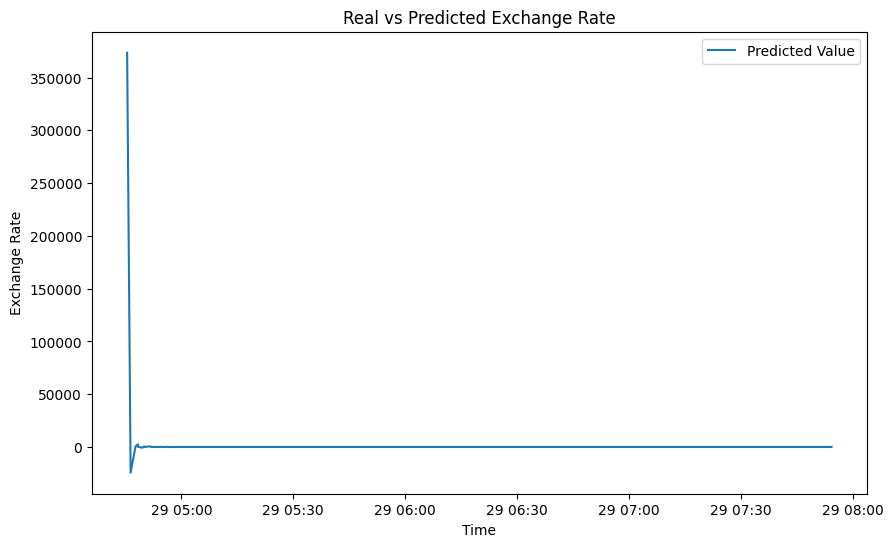

Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 57ms/step
prediction [[1.9300847]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 07:53:02    2.304062         2.087321
2023-05-29 07:53:02    2.304062         2.185465
2023-05-29 07:54:17    2.305192         2.244596
2023-05-29 07:54:17    2.305192         2.256190
2023-05-29 07:54:17    2.305192         1.930085

[306 rows x 2 columns]


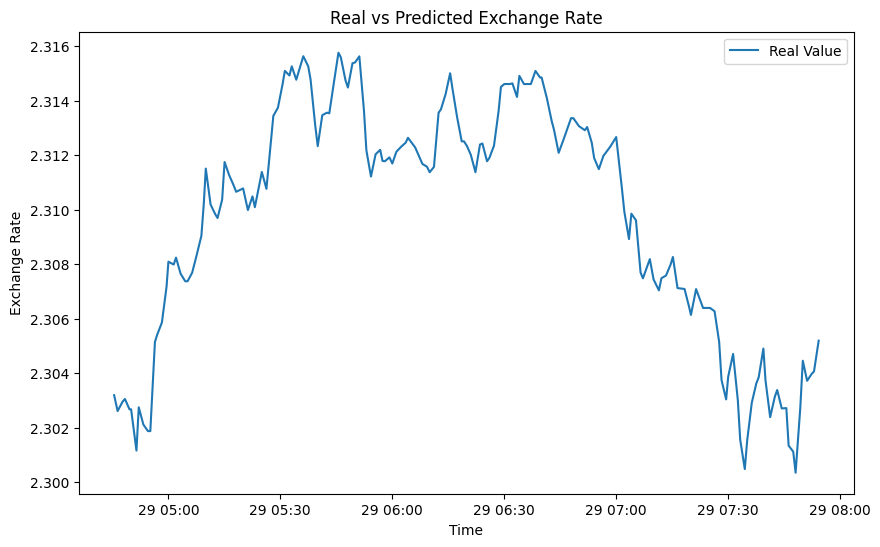

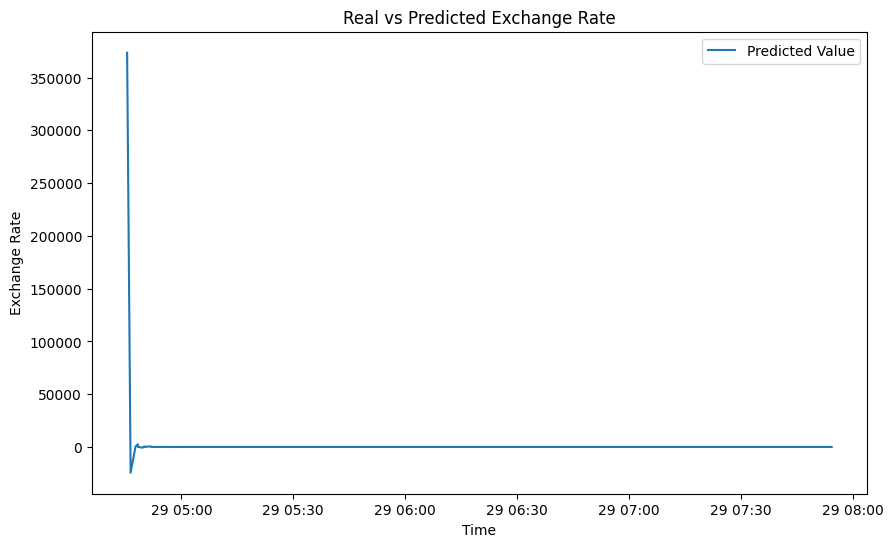

1/1 [==============================] - 0s 51ms/step
prediction [[2.710874]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       405.771637
2023-05-29 04:48:22    2.303049      2490.855225
...                         ...              ...
2023-05-29 07:53:02    2.304062         2.185465
2023-05-29 07:54:17    2.305192         2.244596
2023-05-29 07:54:17    2.305192         2.256190
2023-05-29 07:54:17    2.305192         1.930085
2023-05-29 07:56:16    2.304902         2.710874

[307 rows x 2 columns]
1/1 [==============================] - 0s 47ms/step
prediction [[2.4038007]]
                     real_value  predicted_value
2023-05-29 04:45:28    2.303188    373593.968750
2023-05-29 04:46:24    2.302605    -18911.187500
2023-05-29 04:46:24    2.302605    -24417.710938
2023-05-29 04:47:43    2.302947       4

KeyboardInterrupt: ignored

In [ ]:








# Create an empty DataFrame
df = pd.DataFrame(columns=['exchange_rate', 'bid_price', 'ask_price'])

model = create_lstm_model(n_steps,n_features)

predictions_df = pd.DataFrame(columns=['real_value', 'predicted_value'])

while True:
    forex_exchange = get_forex_exchange(SYMBOL)
    forex_exchange/=1e+6
    if not forex_exchange.empty:
        df = pd.concat([df, forex_exchange]).drop_duplicates()
        num_samples = df.shape[0]
    if num_samples > BATCH_SIZE:
        start_index = num_samples - BATCH_SIZE -1
        end_index = num_samples
       
        features,labels= splitsequence(df.iloc[start_index:,:],n_steps,n_features)
      
        for _ in range(epoch):
          model.train_on_batch(features, labels)

        x_=features[-1].reshape(1,n_steps,n_features)
        predictions = model.predict(x_)

        print("prediction",predictions)
      
        new_predictions = pd.DataFrame({
            'real_value': df['exchange_rate'][end_index-1],
            'predicted_value': predictions[0]
        },index=[pd.to_datetime(df.index[end_index-1])])
        
        predictions_df = pd.concat([predictions_df, new_predictions],ignore_index=False)
        print(predictions_df)
        if num_samples % BATCH_SIZE == 0:
            plot_(predictions_df)


        time.sleep(TIME_DELAY)
    else:
        time.sleep(30)

# 

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [2]:

# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json

In [3]:
json_file = open('/content/sample_data/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/sample_data/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [6]:
optimizer = Adam(0.001,clipnorm=0.01)
loaded_model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['accuracy',RootMeanSquaredError()])

In [ ]:
df = pd.DataFrame(columns=['exchange_rate', 'bid_price', 'ask_price'])

# model = create_lstm_model(n_steps,n_features)

predictions_df = pd.DataFrame(columns=['real_value', 'predicted_value'])

while True:
    forex_exchange = get_forex_exchange(SYMBOL)
    forex_exchange/=1e+6
    if not forex_exchange.empty:
        df = pd.concat([df, forex_exchange]).drop_duplicates()
        num_samples = df.shape[0]
    if num_samples > BATCH_SIZE:
        start_index = num_samples - BATCH_SIZE -1
        end_index = num_samples
       
        features,labels= splitsequence(df.iloc[start_index:,:],n_steps,n_features)
      
        for _ in range(epoch):
          loaded_model.train_on_batch(features, labels)

        x_=features[-1].reshape(1,n_steps,n_features)
        predictions = loaded_model.predict(x_)

        print("prediction",predictions)
      
        new_predictions = pd.DataFrame({
            'real_value': df['exchange_rate'][end_index-1],
            'predicted_value': predictions[0]
        },index=[pd.to_datetime(df.index[end_index-1])])
        
        predictions_df = pd.concat([predictions_df, new_predictions],ignore_index=False)
        print(predictions_df)
        if num_samples % BATCH_SIZE == 0:
            plot_(predictions_df)


        time.sleep(TIME_DELAY)
    else:
        time.sleep(30)

# 

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.DataFrame({
    'col1':np.random.randint(1,100,50),
    'col2':np.random.rand(50)
})
df

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[], df['col1'], label='Real Value')
# plt.plot(data.index, data['predicted_value'], label='Predicted Value')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.title('Real vs Predicted Exchange Rate')
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
# plt.plot(data.index, data['real_value'], label='Real Value')
plt.plot(df.index, df['col2'], label='Predicted Value')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.title('Real vs Predicted Exchange Rate')
plt.legend()
plt.show()